#Introduction:
For our project, we are aiming to see if weather conditions affect the price of corn in the US,
specifically looking at the Corn Belt which is located in the Midwest. One of our datasets comes
from USDA shows the production of corn from 00'-24'. We used this dataset to determine the top
producers within the US. Following that we have a US Weather dataset from Kaggle that shows the
daily weather condtions all over the Untied States from 92'-21'. We used this data to determine
the weather conditions in the Corn Belt which is the area we are observing. Lastly, we had a dataset
that covered the price of corn and it's fluctuations. Some of our visualizations include maps of corn
and weather data as well as charts showing weather and price changes.

#Changes:
For the most part, we haven't changed much with our project. We are still focusing on corn and the prices with
relation to weather. We added a few data sets like the US_GeoCode in order to find longitude and lattitude.
Initally we found a data set that contained corn futures. After cleaning it and processing it we discovered that
it only contains, for every day, ranges between highest and lower price instead of actual prices. This is important because if a price changes throughout the
market day but returns to the original price, the value contained in the dataset won't be 0. We ended up finding a new dataset that we plan to use in the future
that contains opening and closing prices as well as highest and lowest ones, alongside a couple other less relevant insights.
#

In [ ]:
!pip install geodatasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geodatasets
import pandas as pd
import os
import regex as re
import copy
import folium
from branca.colormap import LinearColormap

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  
**SECTION B: weather data cleaning and eda**


The weather dataset consists of data collected from various sensors across the U.S. on different days. It includes maximum temperature, minimum temperature, and precipitation amounts.

- We perform data cleaning by removing NaN and fixing values. Additionally, we conduct exploratory data analysis, plotting the distributions of maximum temperature, minimum temperature, and precipitation recorded by the sensors. We use these distributions to prune corrupted values at the extremes of the distribution.
- We compute the amount of data available for each location and plot the locations on a U.S. map. The higher the amount of data for a location, the stronger its color on the map.
- We recover and compute seasonal trends in the data by grouping the weather data by month and calculating the average values for minimum temperature, maximum temperature, and precipitation.

For each month, we count the number of outliers with respect to the average weather for that month. First, for each day, we compute the deviations from normal monthly conditions and use them to set four flags for each day:
- Hotter: If the maximum temperature deviation from the average is in the 4th quartile,
- Colder: If the minimum temperature deviation from the average is in the 1st - quartile,
- Drier: If the precipitation deviation from the average is in the 1st quartile,
- Wetter: If the precipitation deviation from the average is in the 4th quartile.

We compute the percentage of exceptionality for each month as the ratio of exceptional days to the total number of days in terms of hotness, coldness, dryness, and wetness. Then, we define an exceptional month as one in the 0.9 quantile of the distribution of exceptional months.


In [ ]:
dataset = pd.read_csv("drive/MyDrive/Data_Bandits_CS418/data/weather_data/weather.csv")

#cleaning nan
dataset.dropna(subset=['TMAX','TMIN','PRCP'], how='all')

#select corn belt
data = dataset[
    (dataset['Latitude'] >= 36.5) & (dataset['Latitude'] <= 45.0) &
    (dataset['Longitude'] >= -97.0) & (dataset['Longitude'] <= -84.0)
]

# Extract year and month
data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y', errors='coerce')
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month

# fix temperature unit (in Celsius)
data['TMAX']=data['TMAX']/10
data['TMIN']=data['TMIN']/10

print("size: "+str(data.size))
data.head()

size: 94121940


,ID,DATE,TMAX,TMIN,PRCP,Latitude,Longitude,Elevation,YEAR,MONTH
0,USC00201675,2012-09-26,20.0,10.0,0.0,41.9622,-84.9925,299.9,2012,9
1,USC00230657,2007-05-10,26.7,13.9,3.0,37.0539,-93.5756,399.3,2007,5
2,USC00236045,2008-04-16,15.0,0.6,0.0,36.5869,-89.5325,92.0,2008,4
3,USC00148563,2017-02-20,16.1,6.1,94.0,39.2142,-96.3700,355.4,2017,2
4,USW00013809,2004-07-29,26.7,16.1,0.0,38.7606,-87.5989,130.1,2004,7


max TMAX: 53.9
min TMAX: -45.6


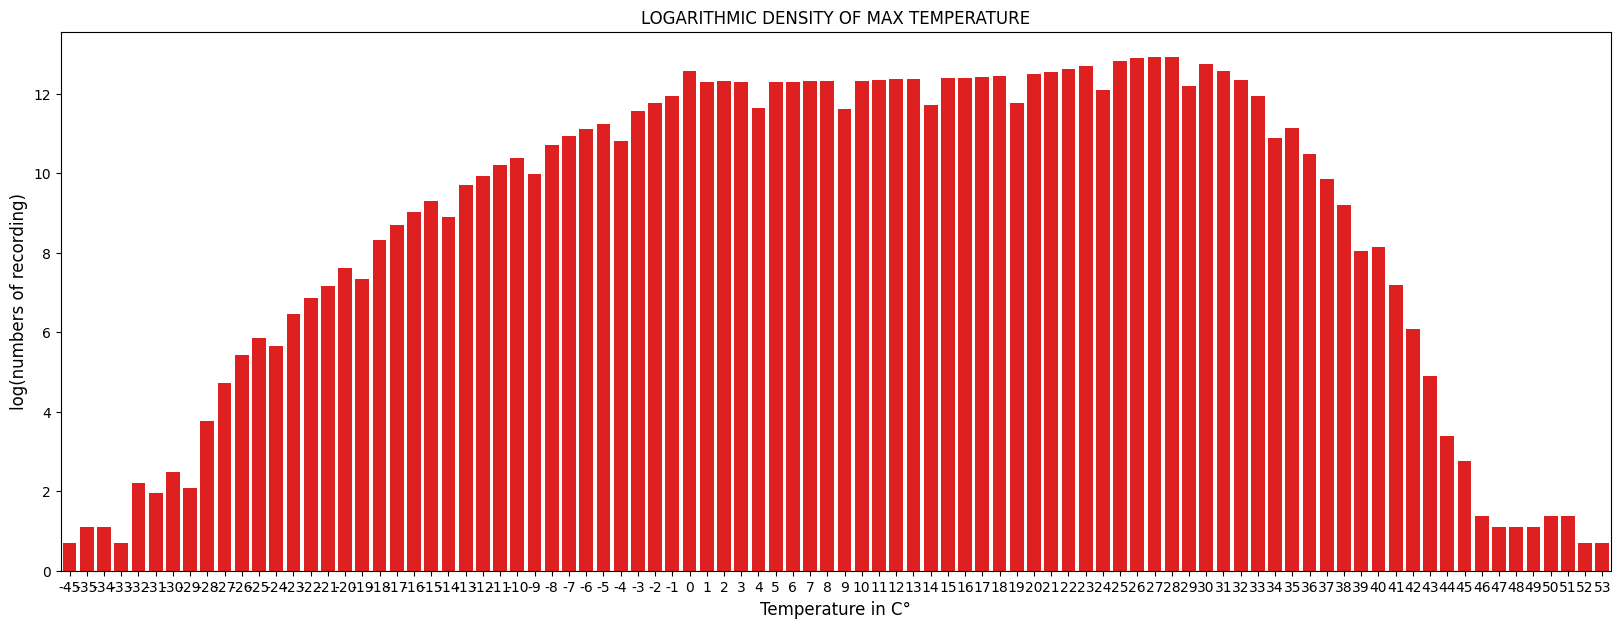

In [ ]:
#exploratory data analysis TMAX
d_aggregate_tmax = data[['TMAX','DATE']].copy()
print("max TMAX: "+str(d_aggregate_tmax['TMAX'].max()))
print("min TMAX: "+str(d_aggregate_tmax['TMAX'].min()))
d_aggregate_tmax['TMAX']=(d_aggregate_tmax['TMAX']).astype(int)
d_aggregate_tmax = d_aggregate_tmax.groupby(['TMAX']).count().reset_index()
d_aggregate_tmax['DATE'] = np.log(d_aggregate_tmax['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_tmax,x='TMAX',y="DATE",color="red")
plt.title("LOGARITHMIC DENSITY OF MAX TEMPERATURE")
plt.xlabel("Temperature in C°", fontsize=12)
plt.ylabel("log(numbers of recording)", fontsize=12)
plt.show()

max TMIN: 42.2
min TMIN: -72.8


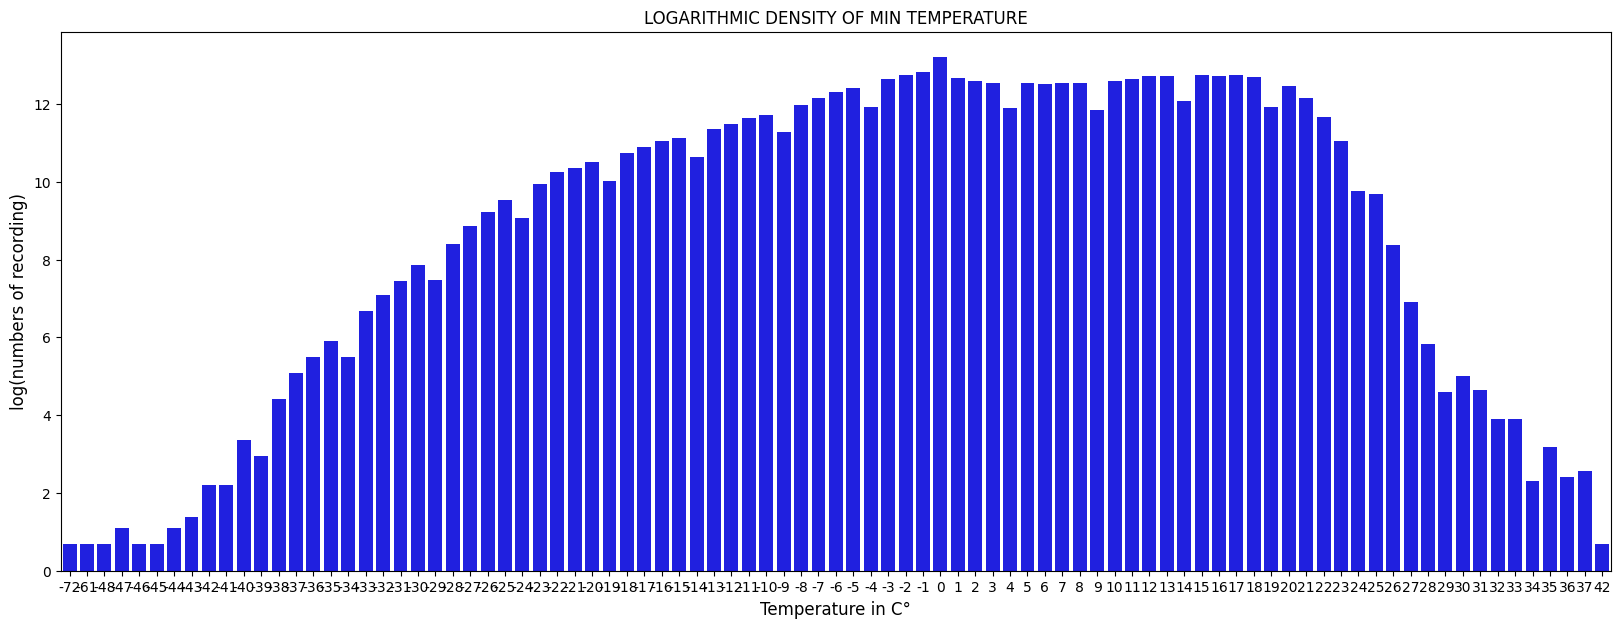

In [ ]:
#exploratory data analysis TMIN
d_aggregate_tmin = data[['TMIN','DATE']].copy()
print("max TMIN: "+str(d_aggregate_tmin['TMIN'].max()))
print("min TMIN: "+str(d_aggregate_tmin['TMIN'].min()))
d_aggregate_tmin['TMIN']=(d_aggregate_tmin['TMIN']).astype(int)
d_aggregate_tmin = d_aggregate_tmin.groupby(['TMIN']).count().reset_index()
d_aggregate_tmin['DATE'] = np.log(d_aggregate_tmin['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_tmin,x='TMIN',y="DATE",color="blue")
plt.xlabel("Temperature in C°", fontsize=12)
plt.ylabel("log(numbers of recording)", fontsize=12)
plt.title("LOGARITHMIC DENSITY OF MIN TEMPERATURE")
plt.show()

max PRCP: 4826.0
min PRCP: 0.0


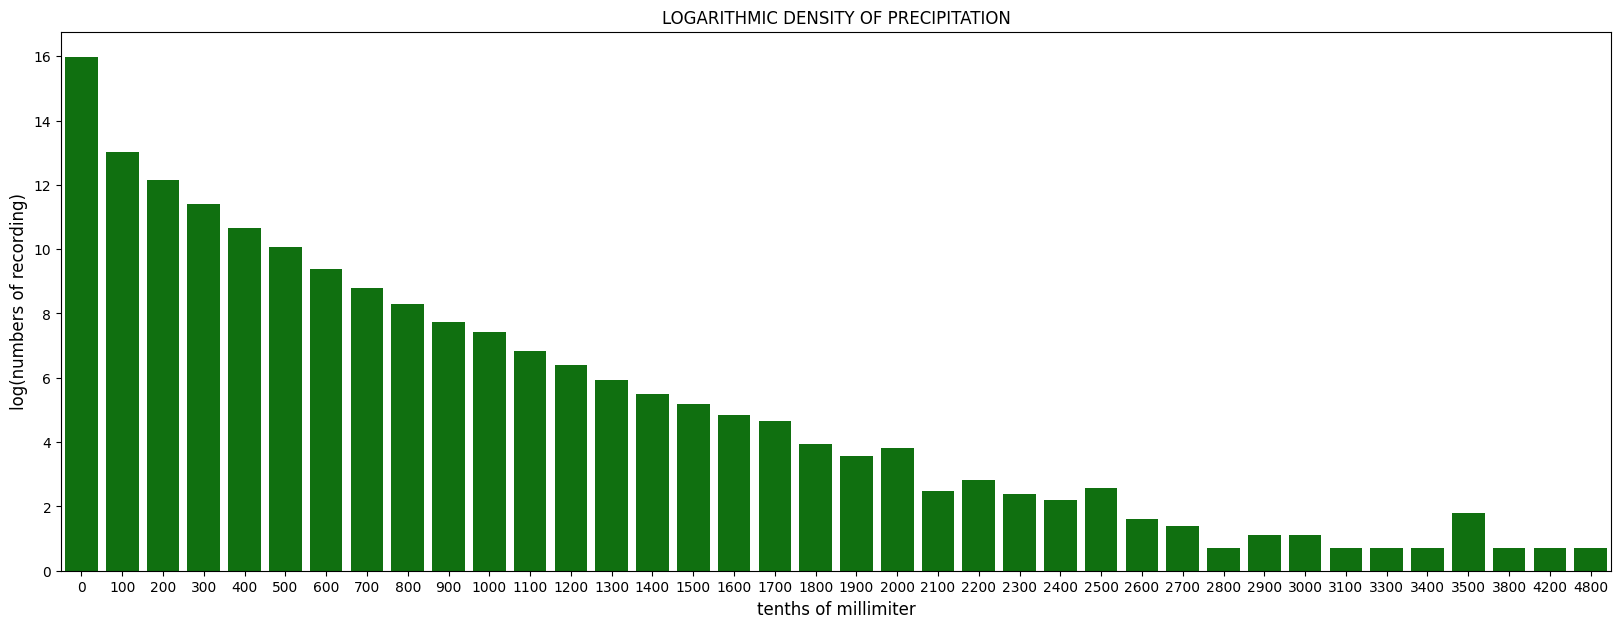

In [ ]:
#exploratory data analysis TMIN
d_aggregate_prcp = data[['PRCP','DATE']].copy()
print("max PRCP: "+str(d_aggregate_prcp['PRCP'].max()))
print("min PRCP: "+str(d_aggregate_prcp['PRCP'].min()))
d_aggregate_prcp['PRCP']=(d_aggregate_prcp['PRCP']/100).astype(int)*100
d_aggregate_prcp = d_aggregate_prcp.groupby(['PRCP']).count().reset_index()
d_aggregate_prcp['DATE'] = np.log(d_aggregate_prcp['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_prcp,x='PRCP',y="DATE",color="green")
plt.xlabel("tenths of millimiter", fontsize=12)
plt.ylabel("log(numbers of recording)", fontsize=12)
plt.title("LOGARITHMIC DENSITY OF PRECIPITATION")
plt.show()

In [ ]:
# clean corrupted value
data_clean = data[(data['TMAX'] < 50) & (data['TMAX'] > -45) &
                  (data['TMIN'] > -45) & (data['TMIN'] < 50) & (data['PRCP'] < 3400)].copy()
print("new size: "+str(data_clean.size))

new size: 94121690


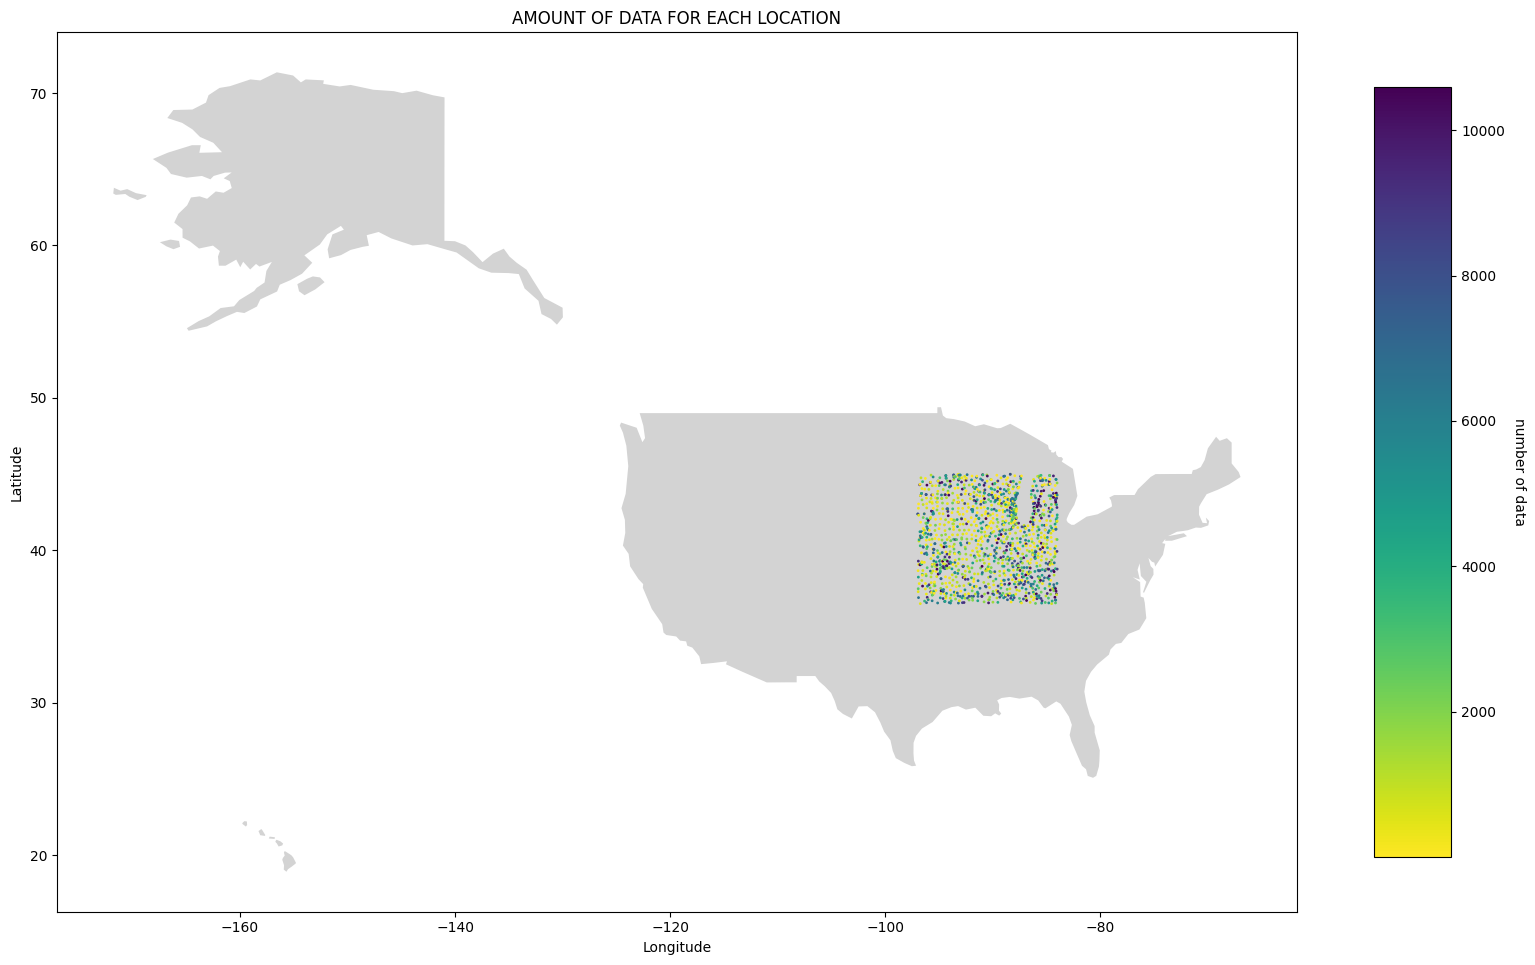

In [ ]:
#compute the number of data for each location
coordinates = data_clean.groupby(['Longitude','Latitude']).size().reset_index(name="days")
min = coordinates['days'].min()
max = coordinates['days'].max()
norm = plt.Normalize(vmin=min, vmax=max)
colors = plt.cm.viridis(norm(coordinates['days']))

# Load and print US map
url = 'https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson'
world = gpd.read_file(url)
usa = world[(world['admin'] == 'United States of America')]
fig, ax = plt.subplots(figsize=(20, 20))
usa.plot(ax=ax, color='lightgrey')

# Plot the points on the map
plt.scatter(coordinates['Longitude'], coordinates['Latitude'], color=colors, marker='o', s=1)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap='viridis_r'), ax=ax, shrink=0.5, aspect=10)
cbar.set_label("number of data", rotation=270, labelpad=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("AMOUNT OF DATA FOR EACH LOCATION")
plt.show()

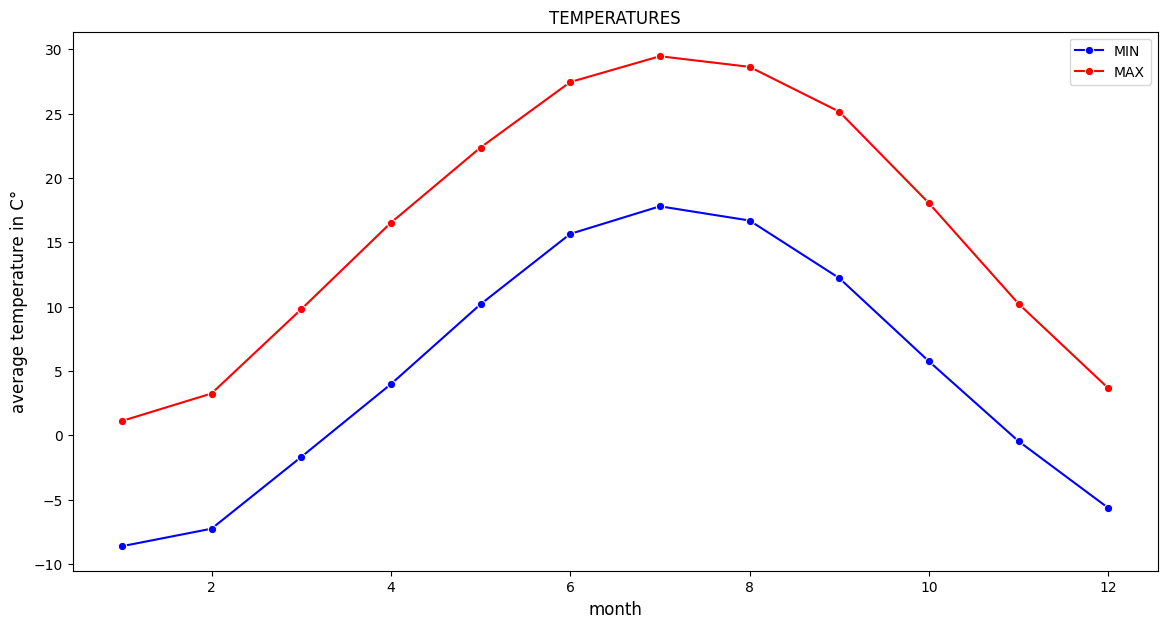

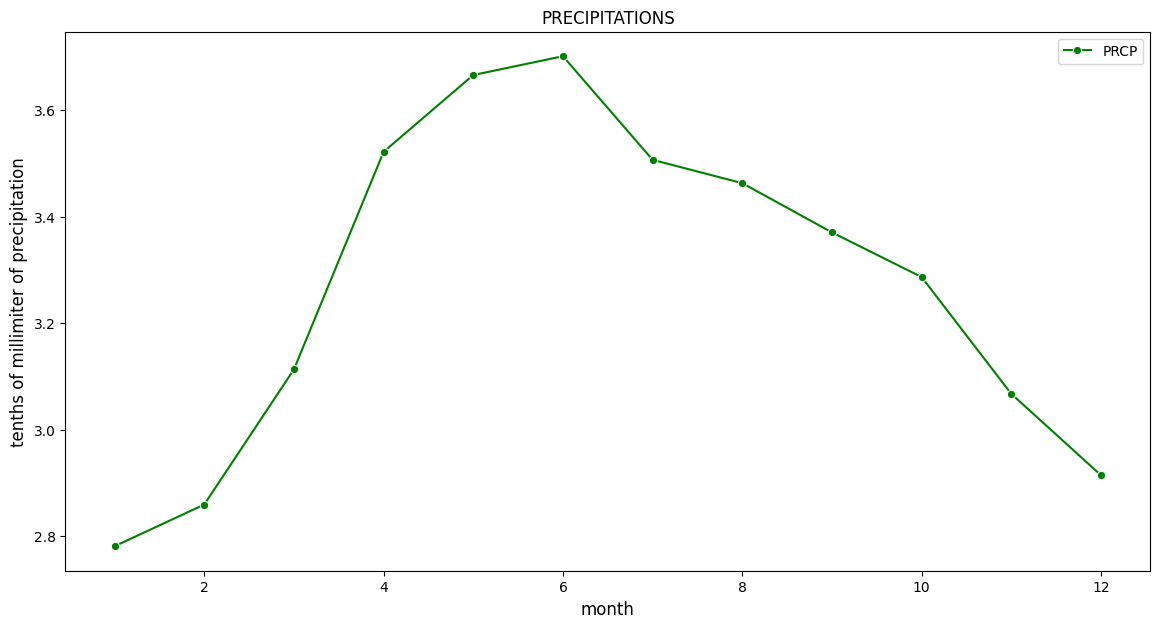

    MONTH       TMIN       TMAX      PRCP
0       1  -8.615716   1.117959  2.781283
1       2  -7.253984   3.252431  2.859564
2       3  -1.682062   9.796652  3.113326
3       4   3.978044  16.520252  3.521793
4       5  10.186761  22.368373  3.665934
5       6  15.655915  27.455557  3.701241
6       7  17.801225  29.465188  3.506713
7       8  16.696339  28.638396  3.462910
8       9  12.223576  25.158060  3.370490
9      10   5.755787  18.049663  3.286595
10     11  -0.455520  10.228568  3.067357
11     12  -5.639670   3.667455  2.914627


In [ ]:
d_aggregate_month = data_clean[['MONTH', 'TMIN', 'TMAX','PRCP']].groupby('MONTH').mean().reset_index()

#plot of seasonal trend for temperature
plt.figure(figsize=(14, 7))
sns.lineplot(data=d_aggregate_month, x="MONTH", y="TMIN", marker="o", label="MIN", color="blue")
sns.lineplot(data=d_aggregate_month, x="MONTH", y="TMAX", marker="o", label="MAX", color="red")
plt.xlabel("month", fontsize=12)
plt.ylabel("average temperature in C°", fontsize=12)
plt.title("TEMPERATURES")
plt.show()

#plot of seasonal trend for precipitation
d_aggregate_month['PRCP'] = np.log(d_aggregate_month['PRCP'])
plt.figure(figsize=(14, 7))
sns.lineplot(data=d_aggregate_month, x="MONTH", y="PRCP", marker="o", label="PRCP", color="green")
plt.xlabel("month", fontsize=12)
plt.ylabel("tenths of millimiter of precipitation", fontsize=12)
plt.title("PRECIPITATIONS")
plt.show()

print(d_aggregate_month)

In [ ]:
#look for exceptional days
d_aggregate_month.rename(columns={'TMIN': 'TMIN_month'}, inplace=True)
d_aggregate_month.rename(columns={'TMAX': 'TMAX_month'}, inplace=True)
d_aggregate_month.rename(columns={'PRCP': 'PRCP_month'}, inplace=True)
d_variation = pd.merge(data_clean, d_aggregate_month, on='MONTH', how='inner')
d_variation['TMIN_dif'] = d_variation['TMIN']-d_variation['TMIN_month']
d_variation['TMAX_dif'] = d_variation['TMAX']-d_variation['TMAX_month']
d_variation['PRCP_dif'] = d_variation['PRCP']-d_variation['PRCP_month']

quartiles = d_variation[['TMIN_dif', 'TMAX_dif', 'PRCP_dif']].quantile([0.25,0.5,0.75])
print(quartiles)

d_exceptional = d_variation.copy()
d_exceptional['colder'] = np.where(d_exceptional['TMIN_dif'] < quartiles.loc[0.25,'TMIN_dif'], 1, 0)
d_exceptional['hotter'] = np.where(d_exceptional['TMAX_dif'] > quartiles.loc[0.75,'TMAX_dif'], 1, 0)
d_exceptional['drier'] = np.where(d_exceptional['PRCP_dif'] < quartiles.loc[0.25,'PRCP_dif'] , 1, 0)
d_exceptional['wetter'] = np.where(d_exceptional['PRCP_dif'] > quartiles.loc[0.75,'PRCP_dif'], 1, 0)
d_exceptional = d_exceptional[['YEAR','MONTH','colder','hotter','drier','wetter']]

      TMIN_dif  TMAX_dif  PRCP_dif
0.25 -3.555787 -4.128568 -3.462910
0.50  0.315716  0.047569 -3.067357
0.75  3.876424  4.161604  4.932643


In [ ]:
#compute the amount of exceptionality for each month
d_exceptional_grouped = d_exceptional.groupby(['YEAR','MONTH']).mean().reset_index()
d_exceptional_grouped['LABEL'] = np.where(d_exceptional_grouped['MONTH'] == 1, d_exceptional_grouped['YEAR'].astype(str), "")
d_exceptional_grouped['DATE'] = d_exceptional_grouped['MONTH'].astype(str) + "_" + d_exceptional_grouped['YEAR'].astype(str)

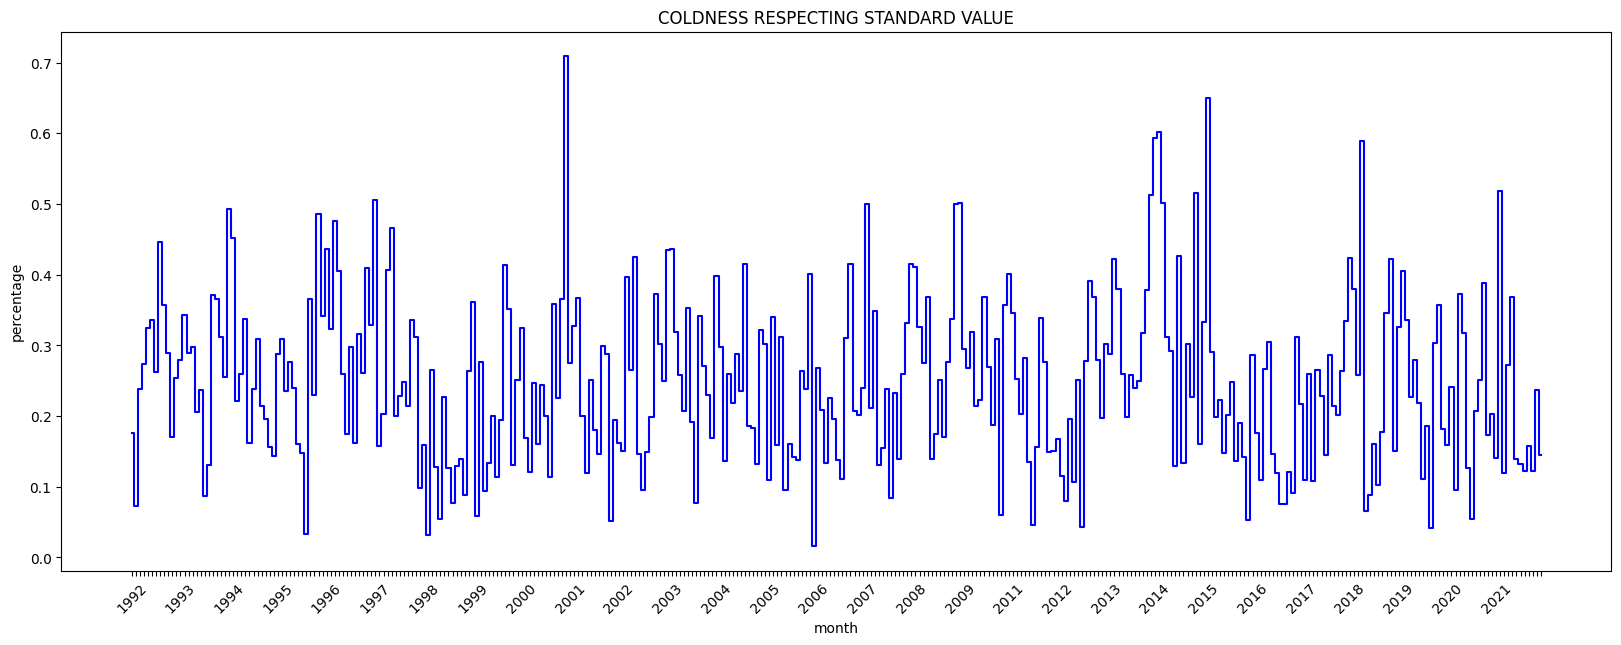

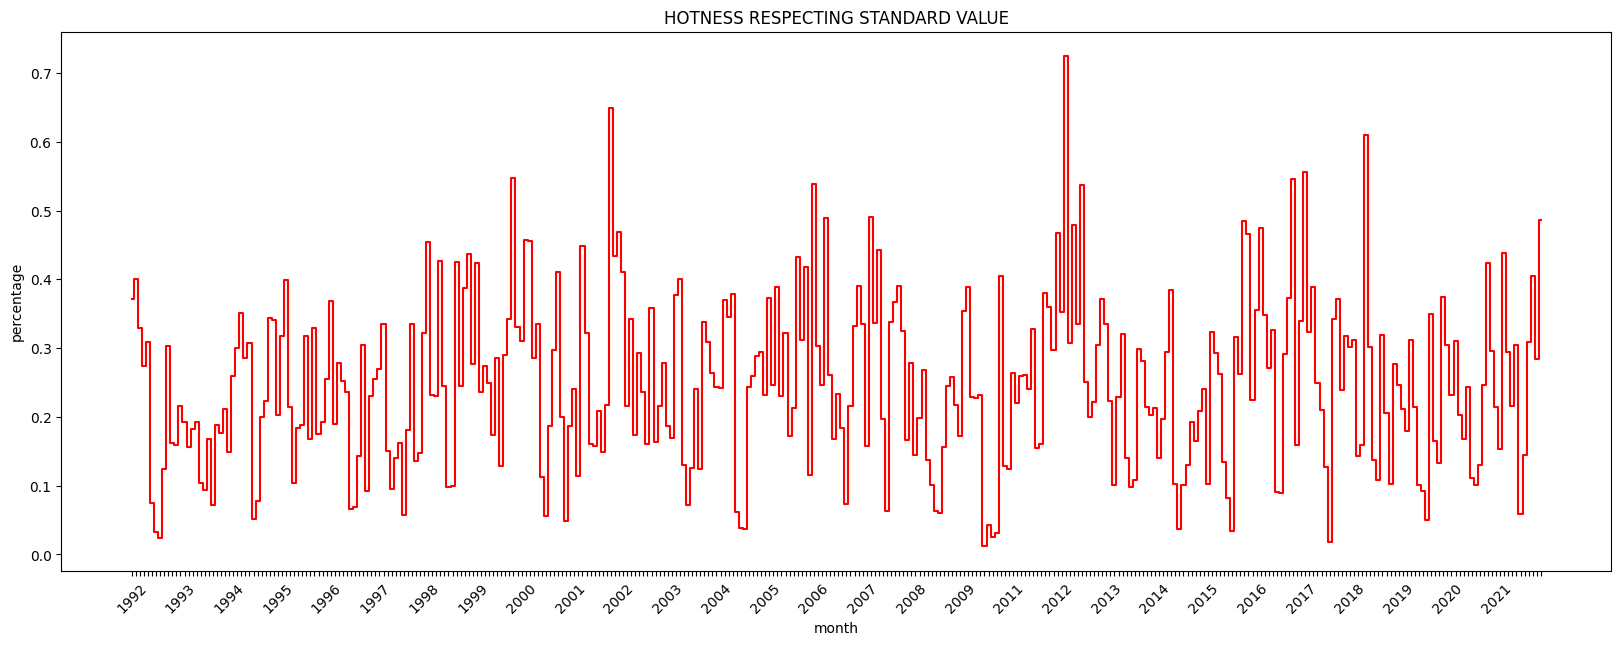

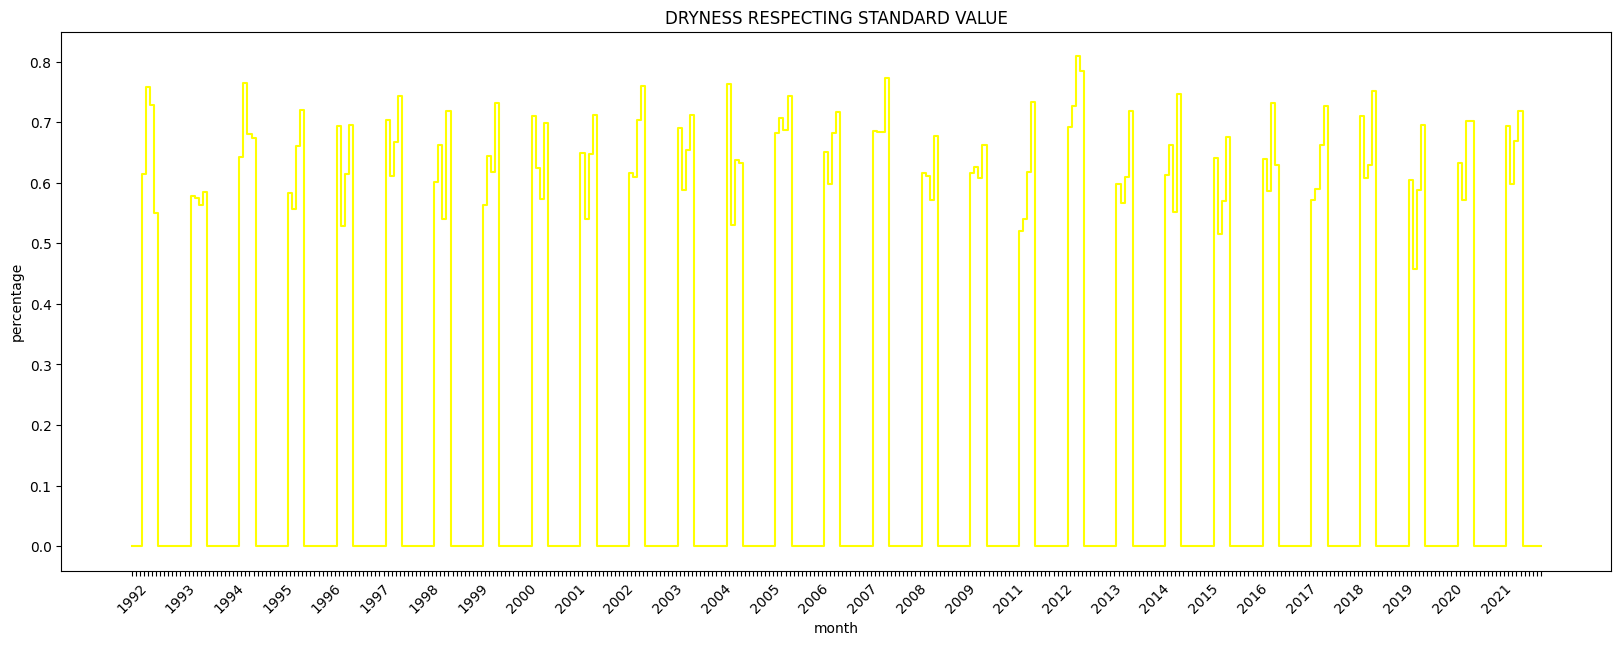

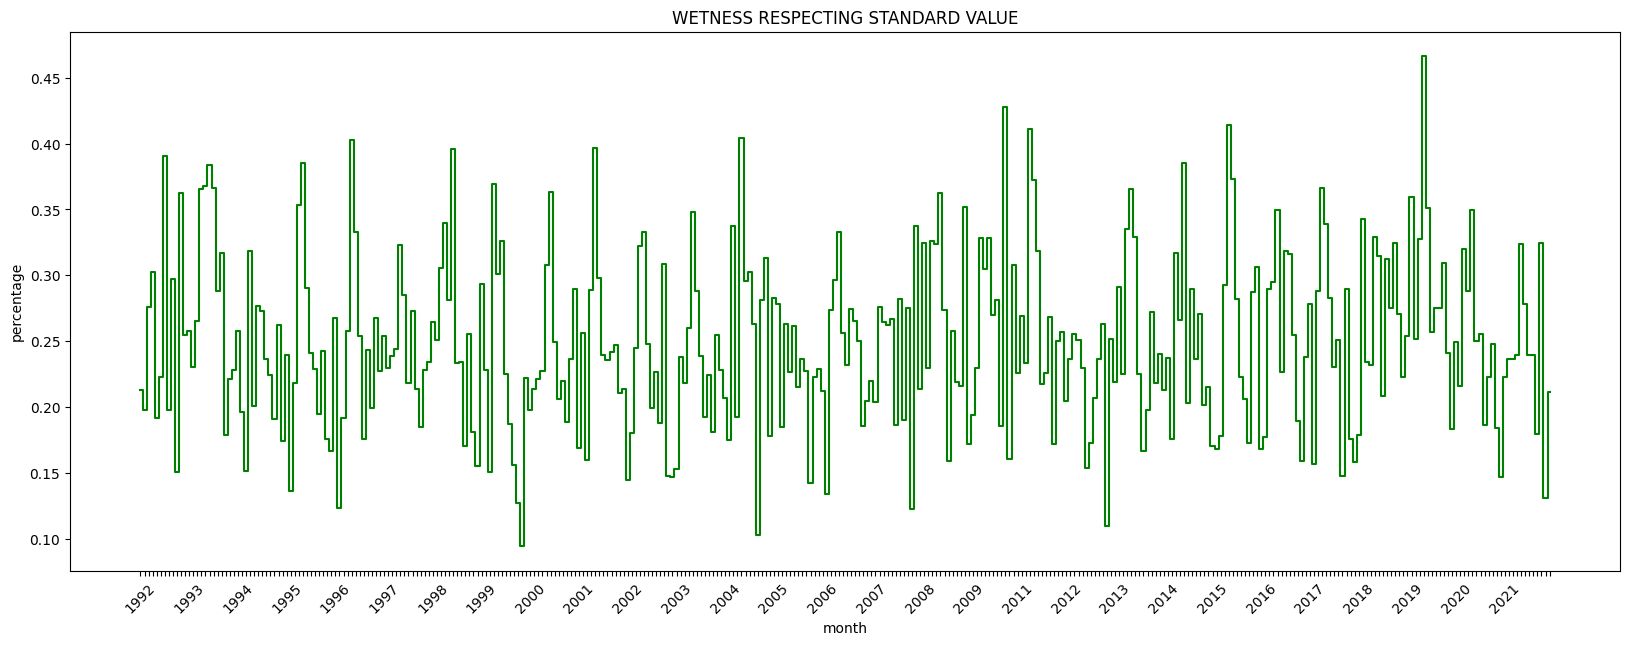

In [ ]:
#plot the amount of exceptionality
plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["colder"], where='mid', color='blue')
plt.xlabel("month")
plt.ylabel("percentage")
plt.title("COLDNESS RESPECTING STANDARD VALUE")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["hotter"], where='mid', color='red')
plt.xlabel("month")
plt.ylabel("percentage")
plt.title("HOTNESS RESPECTING STANDARD VALUE")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["drier"], where='mid', color='yellow')
plt.xlabel("month")
plt.ylabel("percentage")
plt.title("DRYNESS RESPECTING STANDARD VALUE")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["wetter"], where='mid', color="green")
plt.xlabel("month")
plt.ylabel("percentage")
plt.title("WETNESS RESPECTING STANDARD VALUE")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()


In [ ]:
#compute the exceptional month
quartiles2 = d_exceptional_grouped[['hotter', 'colder', 'wetter','drier']].quantile(0.90)
d_exceptional2 = d_exceptional_grouped.copy()
d_exceptional2['colder'] = np.where(d_exceptional_grouped['colder'] > quartiles2['colder'], 1, 0)
d_exceptional2['hotter'] = np.where(d_exceptional_grouped['hotter'] > quartiles2['hotter'], 1, 0)
d_exceptional2['drier'] = np.where(d_exceptional_grouped['drier'] > quartiles2['drier'] , 1, 0)
d_exceptional2['wetter'] = np.where(d_exceptional_grouped['wetter'] > quartiles2['wetter'], 1, 0)

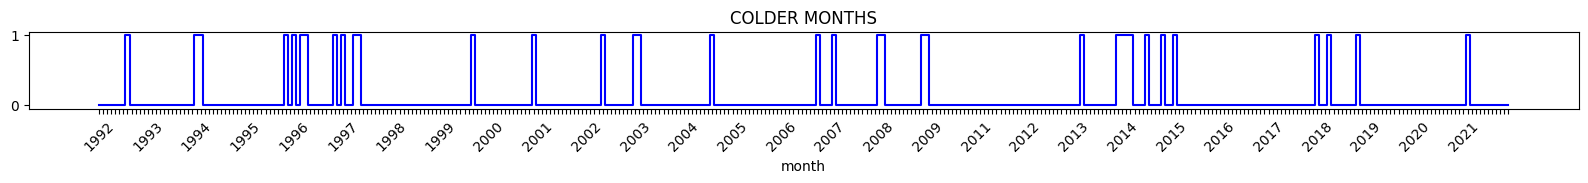

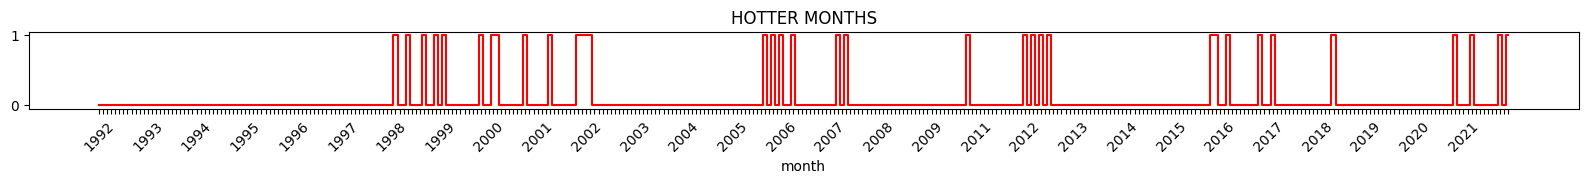

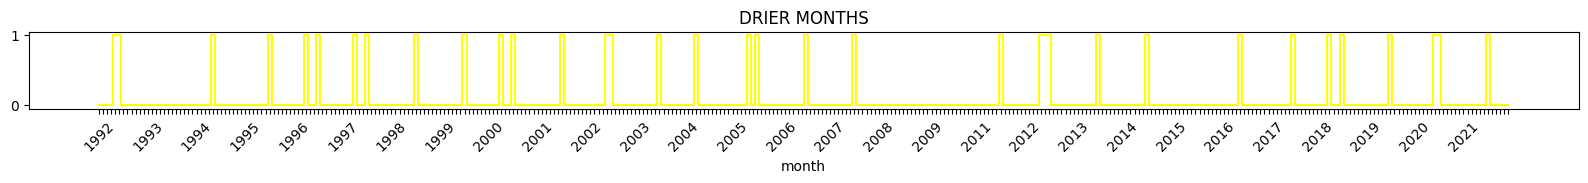

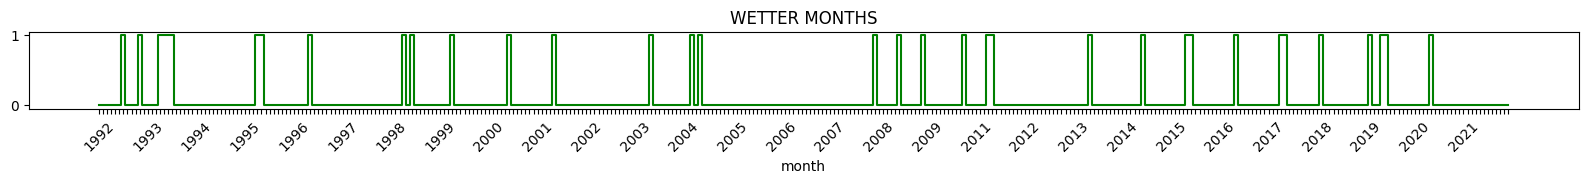

In [ ]:
#plot the exceptional month

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["colder"], where='mid', color='blue')
plt.xlabel("month")
plt.title("COLDER MONTHS")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["hotter"], where='mid', color='red')
plt.xlabel("month")
plt.title("HOTTER MONTHS")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["drier"], where='mid', color='yellow')
plt.xlabel("month")
plt.title("DRIER MONTHS")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["wetter"], where='mid', color='green')
plt.xlabel("month")
plt.title("WETTER MONTHS")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()


In [ ]:
#prepare datasets for machine learning
weather_perc =  d_exceptional_grouped[["YEAR","MONTH","colder","hotter","wetter","drier"]].copy()
weather_bin = d_exceptional2[["YEAR","MONTH","colder","hotter","wetter","drier"]].copy()

Section D: **DATA GATHERING AND EDA ON CORN MONTHLY PRICES**

Here we will gather data concerning crop monthly prices in the US through the USDA qurying system available at https://www.nass.usda.gov/Quick_Stats/ and use that to investigate price behaviour in different states and in different times.

In [ ]:
try:
    path = "/content/drive/MyDrive/Data_Bandits_CS418/data/crop_data/monthly_prices.csv"
    cpm = pd.read_csv(path)
    print("Data loaded successfully")
except FileNotFoundError:
    print("File not found")

cpm.head()

Data loaded successfully


,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,GRAIN in $ / BU
0,2001,COLORADO,8,,,JAN,CORN,2.16
1,2001,COLORADO,8,,,FEB,CORN,2.09
2,2001,COLORADO,8,,,MAR,CORN,2.12
3,2001,COLORADO,8,,,APR,CORN,2.11
4,2001,COLORADO,8,,,MAY,CORN,1.98


In [ ]:
# drop un-interesting cols and rename other ones
cpm = cpm.drop(columns=['STATE ANSI', 'COUNTY ANSI', 'COMMODITY', 'ASD CODE'])
cpm = cpm.rename(columns={
    'LOCATION': 'STATE',
    'REFERENCE PERIOD': 'MONTH',
    'GRAIN in $ / BU': 'PRICE'
})

print(cpm.head())
print(cpm.shape)

   YEAR     STATE MONTH PRICE
0  2001  COLORADO   JAN  2.16
1  2001  COLORADO   FEB  2.09
2  2001  COLORADO   MAR  2.12
3  2001  COLORADO   APR  2.11
4  2001  COLORADO   MAY  1.98
(6706, 4)


In [ ]:
# convert to datetime
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
cpm['MONTH'] = cpm['MONTH'].apply(lambda x: months.index(x) + 1)
cpm['MONTH'] = pd.to_datetime(cpm['MONTH'], format='%m').dt.month
cpm['YEAR'] = pd.to_datetime(cpm['YEAR'], format='%Y').dt.year
cpm = cpm.set_index(['YEAR', 'MONTH', 'STATE'])
cpm = cpm.sort_index()


print(cpm.head())
print(cpm.shape)

                    PRICE
YEAR MONTH STATE         
2001 1     COLORADO  2.16
           GEORGIA   2.54
           ILLINOIS  1.97
           INDIANA   2.03
           IOWA      1.86
(6706, 1)


In [ ]:
# drop the columns with only missing values (if any still exist)
cpm = cpm.dropna(axis=1, how='all')

#count the rows with at least one missing value
row_with_nans = cpm.isna().sum()
print(f"Found {row_with_nans} rows with missing values")

# drop the rows with missing values
cpm = cpm.dropna()


def is_not_a_number(x):
    try:
        float(x)
        return False
    except:
        #print(f"Found a non-number value: {x}")
        return True

cpm['is_not_a_number'] = cpm['PRICE'].apply(is_not_a_number)
cpm = cpm[cpm['is_not_a_number'] == False]
cpm = cpm.drop(columns=['is_not_a_number'])

print(f"Data shape after dropping rows with missing values: {cpm.shape}")

# convert every value of PRICE to float
cpm['PRICE'] = cpm['PRICE'].astype(float)


print(cpm.head())
print(cpm.shape)

Found PRICE    0
dtype: int64 rows with missing values
Data shape after dropping rows with missing values: (5357, 1)
                     PRICE
YEAR MONTH STATE          
2001 1     COLORADO   2.16
           GEORGIA    2.54
           ILLINOIS   1.97
           INDIANA    2.03
           IOWA       1.86
(5357, 1)


In [ ]:
cmp1 = cpm.copy()
# aggregate month and year in dtatetime format
cmp1['DATE'] = pd.to_datetime(cmp1.index.get_level_values('YEAR').astype(str)\
                    + '-' + cmp1.index.get_level_values('MONTH').astype(str))
cmp1 = cmp1.reset_index()
pivot_1 = cmp1.pivot(index='DATE', columns='STATE', values='PRICE')
print(pivot_1.head())
print(pivot_1.shape)

# drop all columns with missing values (and see if we lose too much data)
pivot_1 = pivot_1.dropna(axis=1, how='any')
print(pivot_1.head())
print(pivot_1.shape)

major_producers = [
    "IOWA", "ILLINOIS", "NEBRASKA", "MINNESOTA", "INDIANA", "SOUTH DAKOTA",
    "KANSAS", "OHIO", "WISCONSIN", "MISSOURI", "MICHIGAN", "NORTH DAKOTA",
    "TEXAS", "KENTUCKY", "COLORADO", "PENNSYLVANIA", "TENNESSEE"
]

print(f"Intersection of major producers and states in the data: {set(major_producers) & set(pivot_1.columns)}")
print(f"Major producers not in the data: {set(major_producers) - set(pivot_1.columns)}")
print(f"States in the data not in the major producers: {set(pivot_1.columns) - set(major_producers)}")

# CHOICE: ignore Texas
print("\nResulting clean data (pivoted):\n")
print(pivot_1.head())
print(pivot_1.shape)

STATE       ALABAMA  ARIZONA  ARKANSAS  COLORADO  GEORGIA  IDAHO  ILLINOIS  \
DATE                                                                         
2001-01-01      NaN      NaN       NaN      2.16     2.54    NaN      1.97   
2001-02-01      NaN      NaN       NaN      2.09     2.58    NaN      2.00   
2001-03-01      NaN      NaN       NaN      2.12     2.57    NaN      2.00   
2001-04-01      NaN      NaN       NaN      2.11     2.67    NaN      1.92   
2001-05-01      NaN      NaN       NaN      1.98     2.31    NaN      1.86   

STATE       INDIANA  IOWA  KANSAS  ...  PENNSYLVANIA  SOUTH CAROLINA  \
DATE                               ...                                 
2001-01-01     2.03  1.86    2.07  ...          2.18             NaN   
2001-02-01     2.01  1.87    2.02  ...          2.35             NaN   
2001-03-01     2.02  1.88    2.07  ...          2.30             NaN   
2001-04-01     1.98  1.83    2.02  ...          2.28             NaN   
2001-05-01     1.95  

In the following cell we'll be plotting the behaviour of monthly corn prices along all mnajor producers in years ranging from 2001 to 2024

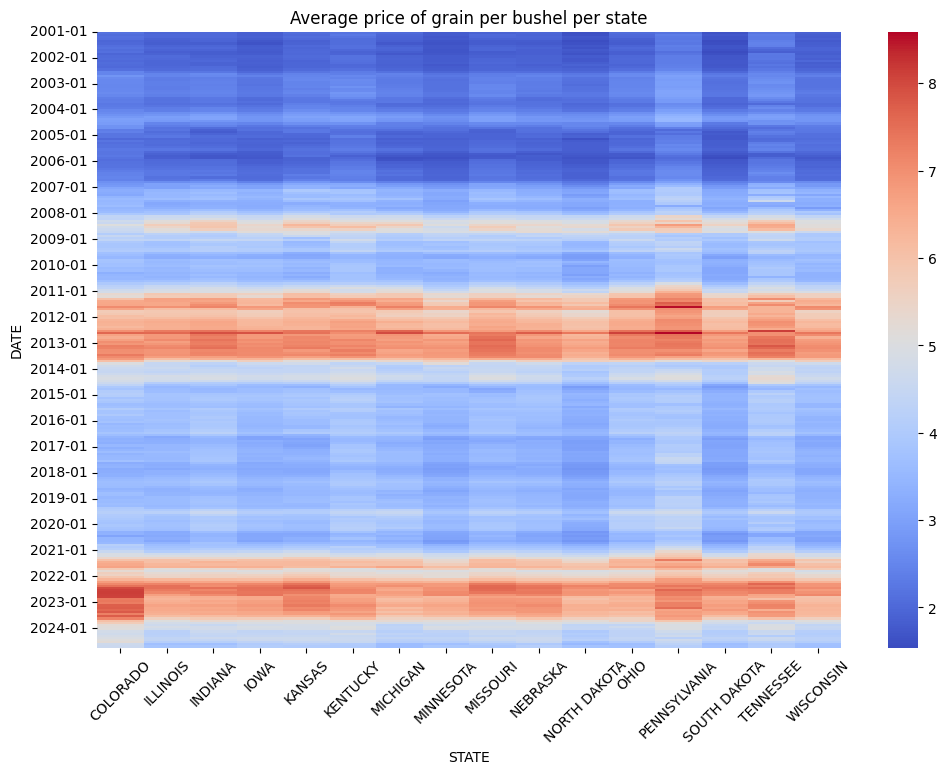

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_1, cmap='coolwarm')
plt.xticks(rotation=45)

year_start_months = pivot_1.index[pivot_1.index.month == 1]
y_ticks = np.arange(0, len(pivot_1.index), 12)  # assuming monthly data, every 12th row
plt.yticks(y_ticks, labels=year_start_months.strftime('%Y-%m'))

plt.title('Average price of grain per bushel per state')
plt.show()

Since from this visualization we can see that states behave almost consistently we can average the prices for all states

In [ ]:
'''
Gather a little bit of stats to guide the analysis
'''
pivot_2 = pivot_1.copy()
pivot_2['STATEWISE_AVERAGE'] = pivot_2.mean(axis=1)
pivot_2 = pivot_2.drop(columns=pivot_2.columns[:-1])

print(pivot_2.head())
print(pivot_2.shape)

pivot_1['STD'] = pivot_1.std(axis=1)
pivot_2['STD'] = pivot_1['STD'] # copying since pivot_2 dropped the columns needed to compute it
pivot_1 = pivot_1.drop(columns=['STD'])

# Now across states
pivot_3 = pivot_1.copy()
pivot_3['MEAN'] = pivot_1.mean(axis=1)
pivot_3['STD']  = pivot_1.std(axis=1)
pivot_3['25p']  = pivot_1.quantile(0.25, axis=1)
pivot_3['50p']  = pivot_1.quantile(0.5, axis=1)
pivot_3['75p']  = pivot_1.quantile(0.75, axis=1)
pivot_3['MIN']  = pivot_1.min(axis=1)
pivot_3['MAX']  = pivot_1.max(axis=1)
insight = pivot_3[pivot_3.columns[-7:]]
print(f"For all months, years...")
print(insight.head())
print(insight.shape)

print(f"\nStatistics over all periods...")
print(insight.describe())

p2_index = pivot_2.index
p2_index = pd.to_datetime(p2_index)
pivot_4 = pd.DataFrame()
pivot_4['STATEWISE AVG'] = pivot_2[['STATEWISE_AVERAGE']].groupby(p2_index.year).mean()
pivot_4['STD'] = pivot_2[['STD']].groupby(p2_index.year).mean()
pivot_4['MIN'] = pivot_1.min(axis=1).groupby(p2_index.year).min()
pivot_4['MAX'] = pivot_1.max(axis=1).groupby(p2_index.year).max()

STATE       STATEWISE_AVERAGE
DATE                         
2001-01-01           1.978750
2001-02-01           1.993750
2001-03-01           1.986250
2001-04-01           1.946250
2001-05-01           1.878125
(285, 1)
For all months, years...
STATE           MEAN       STD     25p    50p     75p   MIN   MAX
DATE                                                             
2001-01-01  1.978750  0.177083  1.8825  2.000  2.1000  1.62  2.21
2001-02-01  1.993750  0.197716  1.8600  2.005  2.0375  1.65  2.35
2001-03-01  1.986250  0.185540  1.8625  1.995  2.0825  1.69  2.30
2001-04-01  1.946250  0.178769  1.8450  1.910  2.0350  1.68  2.29
2001-05-01  1.878125  0.230310  1.7650  1.845  1.9575  1.54  2.39
(285, 7)

Statistics over all periods...
STATE        MEAN         STD         25p         50p         75p         MIN  \
count  285.000000  285.000000  285.000000  285.000000  285.000000  285.000000   
mean     4.020068    0.253896    3.864202    4.003596    4.150237    3.620912   
std      1

Let's now show monthly and yearly averages and standard deviations (aggregating states as they show uniform behaviour) to identify temporal outliers in corn pricing.

            STATEWISE AVG       STD   MIN   MAX
DATE                                           
2001-01-01       1.933906  0.186434  1.54  2.44
2001-02-01       1.933906  0.186434  1.54  2.44
2001-03-01       1.933906  0.186434  1.54  2.44
2001-04-01       1.933906  0.186434  1.54  2.44
2001-05-01       1.933906  0.186434  1.54  2.44
(285, 4)


<ipython-input-33-478c5a931101>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp3 = temp3.fillna(method='ffill')


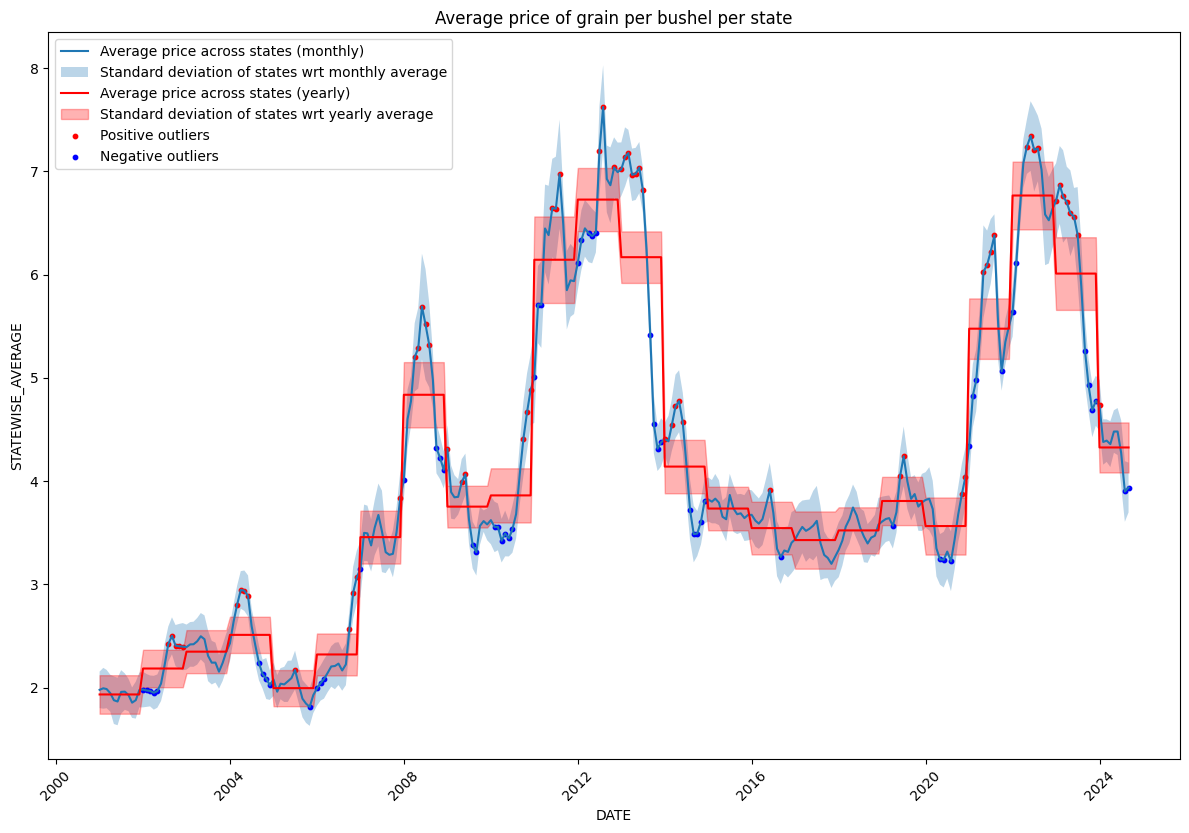

In [ ]:
temp3_index = pivot_2.index
# Create temp3 with the new index and replicate the values of each year for all months
temp3 = pd.DataFrame(index=temp3_index)

for col in pivot_4.columns:
    temp3[col] = temp3.index.year.map(pivot_4[col])


temp3 = temp3.fillna(method='ffill')

print(temp3.head())
print(temp3.shape)

# now let's use that to highlight the months where the monthly average is above the yearly average + yearly std
pivot_2['YEARLY_AVG'] = temp3['STATEWISE AVG']
pivot_2['YEARLY_STD'] = temp3['STD']
pivot_2['YEARLY_AVG_STD'] = pivot_2['YEARLY_AVG'] + pivot_2['YEARLY_STD']
pivot_2['MONTHLY_ABOVE_YEARLY'] = pivot_2['STATEWISE_AVERAGE'] > pivot_2['YEARLY_AVG_STD']
pivot_2['MONTHLY_ABOVE_YEARLY'] = pivot_2['MONTHLY_ABOVE_YEARLY'].astype(int)
pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] = pivot_2['STATEWISE_AVERAGE'] < pivot_2['YEARLY_AVG'] - pivot_2['YEARLY_STD']
pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] = pivot_2['MONTHLY_BELOW_MINUS_YEARLY'].astype(int)

plt.figure(figsize=(12, 8))
sns.lineplot(data=pivot_2, x=pivot_2.index, y='STATEWISE_AVERAGE', label='Average price across states (monthly)')
plt.fill_between(pivot_2.index, pivot_2['STATEWISE_AVERAGE'] - pivot_2['STD'], \
                 pivot_2['STATEWISE_AVERAGE'] + pivot_2['STD'], alpha=0.3, label='Standard deviation of states wrt monthly average')
sns.lineplot(data=temp3, x=temp3.index, y='STATEWISE AVG', color='red', label='Average price across states (yearly)')
plt.fill_between(temp3.index, temp3['STATEWISE AVG'] - temp3['STD'], \
                 temp3['STATEWISE AVG'] + temp3['STD'], alpha=0.3, color='red', label='Standard deviation of states wrt yearly average')
plt.scatter(
    pivot_2.index[pivot_2['MONTHLY_ABOVE_YEARLY'] == 1],
    pivot_2['STATEWISE_AVERAGE'][pivot_2['MONTHLY_ABOVE_YEARLY'] == 1],
    c='red', s=10, label='Positive outliers'
)
plt.scatter(
    pivot_2.index[pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] == 1],
    pivot_2['STATEWISE_AVERAGE'][pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] == 1],
    c='blue', s=10, label='Negative outliers'
)

plt.tight_layout()
plt.legend()
plt.xticks(rotation=45)
plt.title('Average price of grain per bushel per state')

outliers = pivot_2[(pivot_2['MONTHLY_ABOVE_YEARLY'] == 1) | (pivot_2['MONTHLY_BELOW_MINUS_YEARLY'] == 1)]

plt.show()

# E: ***CORN_PRODUCTION_YEARLY***

### In this section we cleaned our data be removing commas, filterning out missing data, and selecting states based on multiple filters.


In [ ]:
# Read the crop.csv file into a DataFrame
colab = True

if colab:
    corn_production = pd.read_csv('/content/drive/MyDrive/Data_Bandits_CS418/data/crop_data/corn.csv')
else:
    corn_production = pd.read_csv('../data/crop_data/corn.csv')

### Clean dataframe by detecting missing values by filtering out everything which is not a number, then convert strings to ints and set a decision boundary for major producing states

In [ ]:
cleaned_df = copy.deepcopy(corn_production)


cleaned_df["PriceIsNan"] = corn_production["PRICE RECEIVED in $ / BU"].apply(lambda x: not bool(re.match(r'^[0-9]', str(x))))
cleaned_df["AreaisNan"] = corn_production["AREA PLANTED in ACRES"].apply(lambda x: not bool(re.match(r'^[0-9]', str(x))))

# Filter rows where "AREA PLANTED in ACRES" is greater than 300,000
# First remove commas from the values and convert to numeric
cleaned_df = corn_production[cleaned_df['AreaisNan'] == False]
cleaned_df["AREA PLANTED in ACRES"] = cleaned_df["AREA PLANTED in ACRES"].str.replace(',', '').astype(int)
cleaned_df = cleaned_df[cleaned_df["AREA PLANTED in ACRES"] > 3000000]

<ipython-input-35-c8511ee21a1e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["AREA PLANTED in ACRES"] = cleaned_df["AREA PLANTED in ACRES"].str.replace(',', '').astype(int)


The following are the major producers of corn

In [ ]:
cleaned_df.head()

,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,AREA HARVESTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,AREA PLANTED in ACRES,PRODUCTION in $,PRODUCTION in TONS,YIELD in TONS / ACRE,PRICE RECEIVED in $ / BU
10,2000,ILLINOIS,17,,,YEAR,CORN,,,,11200000,,,,
11,2000,INDIANA,18,,,YEAR,CORN,,,,5700000,,,,
12,2000,IOWA,19,,,YEAR,CORN,,,,12300000,,,,
13,2000,KANSAS,20,,,YEAR,CORN,,,,3450000,,,,
20,2000,MINNESOTA,27,,,YEAR,CORN,,,,7200000,,,,


In [ ]:
# Creates a clean copy of the data
cleaned_df = copy.deepcopy(corn_production)

# Filter for corn grain only
cleaned_df = cleaned_df[cleaned_df['COMMODITY'] == "CORN, GRAIN"]

# Creates separate dataframes for year and marketing year rows
year_df = cleaned_df[cleaned_df['REFERENCE PERIOD'] == 'YEAR'].copy()
marketing_year_df = cleaned_df[cleaned_df['REFERENCE PERIOD'] == 'MARKETING YEAR'].copy()

# Creates a mapping of (location, year) to price
price_mapping = marketing_year_df.set_index(['LOCATION', 'YEAR'])['PRICE RECEIVED in $ / BU']

# Map the prices to the year rows using location and year as keys
year_df['PRICE RECEIVED in $ / BU'] = year_df.apply(
    lambda row: price_mapping.get((row['LOCATION'], row['YEAR']), None),
    axis=1
)

# This will be our final dataframe
cleaned_df = year_df

# Drop unnecessary columns
cleaned_df = cleaned_df.drop(["PRODUCTION in TONS", "COMMODITY", "ASD CODE", "COUNTY ANSI", "AREA PLANTED in ACRES", "YIELD in TONS / ACRE", "STATE ANSI"], axis=1)

The dataset used to have the production and price over multiple rows, we merge the rows based on state and year, then we remove columns with no values

In [ ]:
cleaned_df.head()

,YEAR,LOCATION,REFERENCE PERIOD,AREA HARVESTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,PRODUCTION in $,PRICE RECEIVED in $ / BU
1210,2000,ALABAMA,YEAR,"165,000","10,725,000",65,"23,166,000",2.16
1212,2000,ARIZONA,YEAR,"33,000","6,468,000",196,"17,981,000",2.78
1214,2000,ARKANSAS,YEAR,"175,000","22,750,000",130,"39,813,000",1.75
1216,2000,CALIFORNIA,YEAR,"205,000","34,850,000",170,"85,034,000",2.44
1218,2000,COLORADO,YEAR,"1,150,000","144,900,000",126,"301,392,000",2.08


In [ ]:
# Convert both columns to numeric
cleaned_df['PRODUCTION in BU'] = pd.to_numeric(
    cleaned_df['PRODUCTION in BU'].astype(str).str.replace(',', ''),
    errors='coerce'
)

cleaned_df['PRICE RECEIVED in $ / BU'] = pd.to_numeric(
    cleaned_df['PRICE RECEIVED in $ / BU'],
    errors='coerce'
)

# Group by location and calculate mean for numeric columns
location_averages = cleaned_df.groupby('LOCATION').agg({
    'PRODUCTION in BU': 'mean',
    'PRICE RECEIVED in $ / BU': 'mean'
}).round(2)

# Sort by area harvested to see largest producers first
location_averages = location_averages.sort_values('PRODUCTION in BU', ascending=False)

# Display the results
print("Number of locations:", len(location_averages))
location_averages

Number of locations: 42


,PRODUCTION in BU,PRICE RECEIVED in $ / BU
LOCATION,,
IOWA,2.275598e+09,3.88
ILLINOIS,2.004372e+09,3.90
NEBRASKA,1.492326e+09,3.88
MINNESOTA,1.254270e+09,3.75
INDIANA,9.030940e+08,4.00
SOUTH DAKOTA,6.224828e+08,3.68
KANSAS,5.421356e+08,3.92
OHIO,5.188112e+08,3.98
WISCONSIN,4.597904e+08,3.79


In [ ]:
corn_production.head()

,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,AREA HARVESTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,AREA PLANTED in ACRES,PRODUCTION in $,PRODUCTION in TONS,YIELD in TONS / ACRE,PRICE RECEIVED in $ / BU
0,2000,ALABAMA,01,,,YEAR,CORN,,,,"230,000",,,,
1,2000,ARIZONA,04,,,YEAR,CORN,,,,"56,000",,,,
2,2000,ARKANSAS,05,,,YEAR,CORN,,,,"180,000",,,,
3,2000,CALIFORNIA,06,,,YEAR,CORN,,,,"540,000",,,,
4,2000,COLORADO,08,,,YEAR,CORN,,,,"1,350,000",,,,


In [ ]:
# Filter for locations with >= 1 million acres harvested
major_producers = location_averages[location_averages['PRODUCTION in BU'] >= 100_000_000]

# Display the results
print("Number of major producing locations:", len(major_producers))
major_producers

Number of major producing locations: 17


,PRODUCTION in BU,PRICE RECEIVED in $ / BU
LOCATION,,
IOWA,2.275598e+09,3.88
ILLINOIS,2.004372e+09,3.90
NEBRASKA,1.492326e+09,3.88
MINNESOTA,1.254270e+09,3.75
INDIANA,9.030940e+08,4.00
SOUTH DAKOTA,6.224828e+08,3.68
KANSAS,5.421356e+08,3.92
OHIO,5.188112e+08,3.98
WISCONSIN,4.597904e+08,3.79


In [ ]:
#This dataset contains the longitude and latitude values of each state which will
#be used to join with the major producers dataframe to create a visualization.
state_data = pd.read_csv('/content/drive/MyDrive/Data_Bandits_CS418/data/crop_data/US_GeoCode.csv')

# Make all the state names uppercase so that it matches the corn data
state_data['Name'] = state_data['Name'].str.upper()

# Merge the state longitude and latitude with the corn data
merged_data = pd.merge(major_producers, state_data, left_on='LOCATION', right_on='Name')

print(merged_data.head())


   PRODUCTION in BU  PRICE RECEIVED in $ / BU state&teritory   latitude  \
0      2.275598e+09                      3.88             IA  41.878003   
1      2.004372e+09                      3.90             IL  40.633125   
2      1.492326e+09                      3.88             NE  41.492537   
3      1.254270e+09                      3.75             MN  46.729553   
4      9.030940e+08                      4.00             IN  40.551217   

   longitude       Name  
0 -93.097702       IOWA  
1 -89.398528   ILLINOIS  
2 -99.901813   NEBRASKA  
3 -94.685900  MINNESOTA  
4 -85.602364    INDIANA  


In [ ]:
# Create a map centered in the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4, tiles="cartodb positron")
scaling_factor = 60000000

# Color scale used to show the production of corn
max_production = merged_data['PRODUCTION in BU'].astype(float).max()
colormap = LinearColormap(colors=['lightyellow', 'orange', 'darkorange', 'brown'],
                          vmin=0, vmax=max_production, caption="Corn Production in Bushels")

# Title to add to the map
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Corn Production Visualization by State</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Legend of the map
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 200px; height: 100px;
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 padding: 10px;">
     <b>Legend</b><br>
     <i style="background:brown; width:10px; height:10px; float:left; margin-right:5px; opacity:0.7;"></i> High Production<br>
     <i style="background:lightyellow; width:10px; height:10px; float:left; margin-right:5px; opacity:0.7;"></i> Low Production<br>
     <i style="background:white; width:10px; height:10px; float:left; margin-right:5px; border:1px solid black;"></i> No Data
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add circle markers for each state
for _, row in merged_data.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        radius = float(row['PRODUCTION in BU']) / scaling_factor
        color = colormap(float(row['PRODUCTION in BU']))  # Get color from colormap based on production

        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=radius,
            color="black",
            fill=True,
            fill_color=color,  # Fill with gradient color based on production
            fill_opacity=0.6,
            tooltip=f"{row['Name']} - Production: {row['PRODUCTION in BU']} BU"  # Tooltip for hover
        ).add_to(m)


colormap.add_to(m)
m

SECTION F: Range data commodities


The dataset is filtered to retain only essential columns (Date, Range_C_F1, and Range_C_F2), with dates after January 1, 1992. A new column, Volatility_Difference, is calculated as the difference between Range_C_F1 (price range of the nearby contract) and Range_C_F2 (price range of the second expiration). A positive Volatility_Difference indicates higher short-term uncertainty, as the nearby contract is more volatile. Conversely, a negative value suggests greater long-term volatility, reflecting market concerns or instability over longer horizons.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Bandits_CS418/rangedata_commodities_since1877.csv')

In [ ]:
df_corn = df[['Date', 'Range_C_F1', 'Range_C_F2']]

In [ ]:
df_corn['Date'] = pd.to_datetime(df_corn['Date'], format='%d-%m-%Y')
df_corn_filtered = df_corn[df_corn['Date'] > '1992-01-01']

<ipython-input-46-e2ec65c8ec2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn['Date'] = pd.to_datetime(df_corn['Date'], format='%d-%m-%Y')


In [ ]:
df_corn_filtered['Volatility_Difference'] = df_corn_filtered['Range_C_F1'] - df_corn_filtered['Range_C_F2']

<ipython-input-47-3c41bcd6a19f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn_filtered['Volatility_Difference'] = df_corn_filtered['Range_C_F1'] - df_corn_filtered['Range_C_F2']


# Descriptive Statistics

<ipython-input-48-8f1b87e5d60e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn_filtered['Range_C_F1_MA30'] = df_corn_filtered['Range_C_F1'].rolling(window=30).mean()
<ipython-input-48-8f1b87e5d60e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn_filtered['Range_C_F2_MA30'] = df_corn_filtered['Range_C_F2'].rolling(window=30).mean()
<ipython-input-48-8f1b87e5d60e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

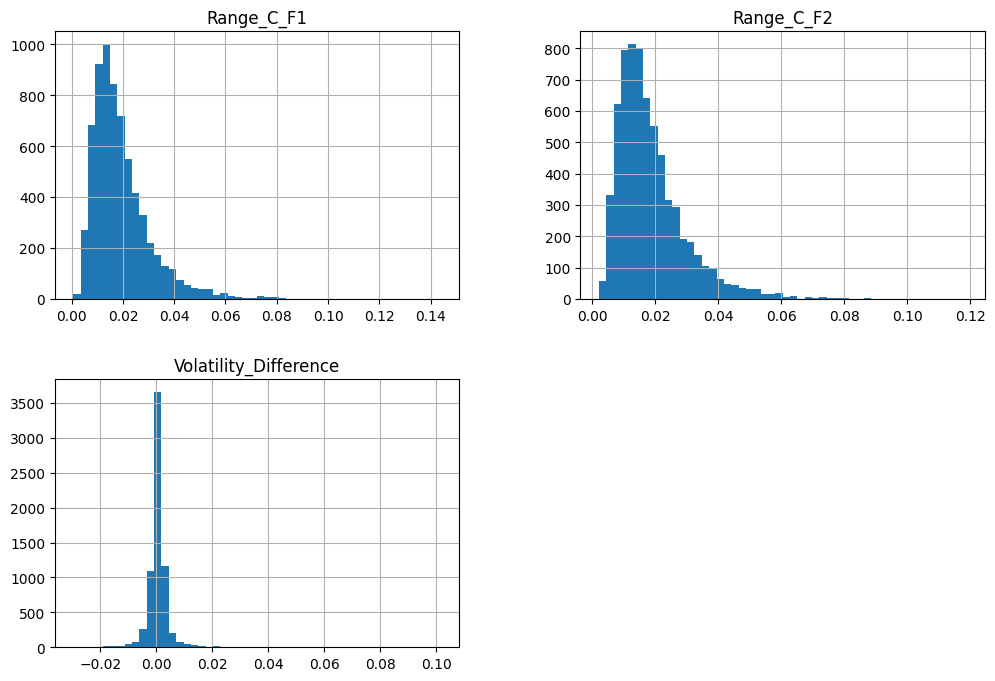

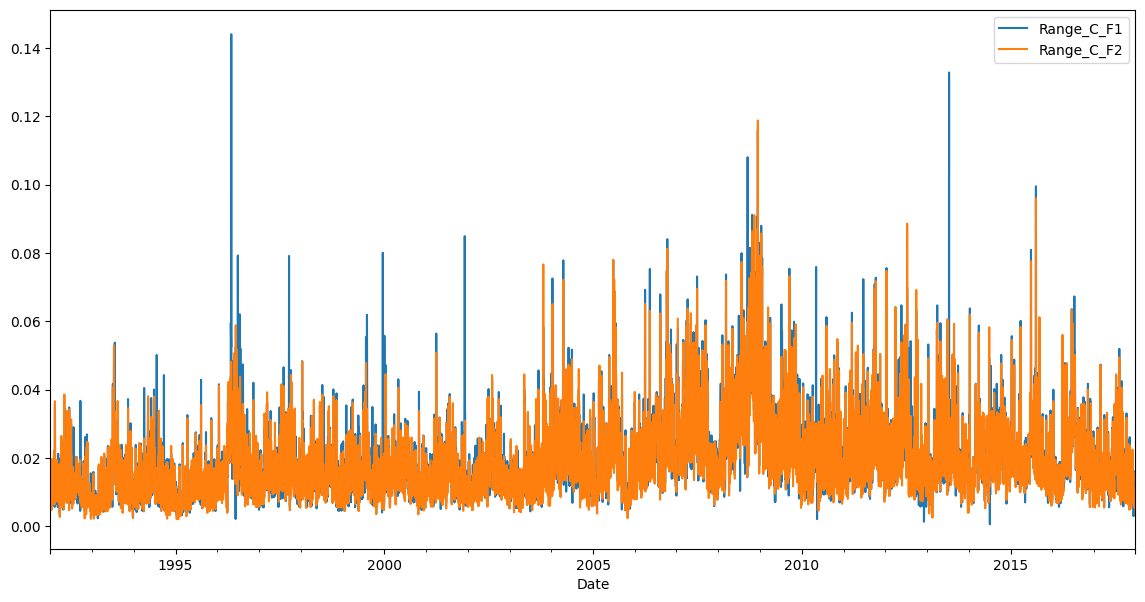

In [ ]:
if 'Date' not in df_corn_filtered.columns:
    df_corn_filtered = df_corn_filtered.reset_index()

df_corn_filtered[['Range_C_F1', 'Range_C_F2', 'Volatility_Difference']].describe()

df_corn_filtered[['Range_C_F1', 'Range_C_F2', 'Volatility_Difference']].hist(bins=50, figsize=(12, 8))

df_corn_filtered.plot(x='Date', y=['Range_C_F1', 'Range_C_F2'], figsize=(14, 7))

df_corn_filtered['Range_C_F1_MA30'] = df_corn_filtered['Range_C_F1'].rolling(window=30).mean()
df_corn_filtered['Range_C_F2_MA30'] = df_corn_filtered['Range_C_F2'].rolling(window=30).mean()
df_corn_filtered['Volatility_Difference_MA30'] = df_corn_filtered['Volatility_Difference'].rolling(window=30).mean()

correlation = df_corn_filtered[['Range_C_F1', 'Range_C_F2']].corr()

df_corn_filtered['Year'] = df_corn_filtered['Date'].dt.year
df_corn_filtered['Month'] = df_corn_filtered['Date'].dt.month
monthly_avg = df_corn_filtered.groupby(['Year', 'Month'])[['Range_C_F1', 'Range_C_F2', 'Volatility_Difference']].mean()

q1 = df_corn_filtered['Volatility_Difference'].quantile(0.25)
q3 = df_corn_filtered['Volatility_Difference'].quantile(0.75)
iqr = q3 - q1
outliers = df_corn_filtered[(df_corn_filtered['Volatility_Difference'] < (q1 - 1.5 * iqr)) | (df_corn_filtered['Volatility_Difference'] > (q3 + 1.5 * iqr))]


We plot a graph of the 30-day moving averages for Range_C_F1 and Range_C_F2, represented by the blue and orange lines, respectively. Moving averages smooth out the noise from daily fluctuations, allowing long-term price trends to be observed.

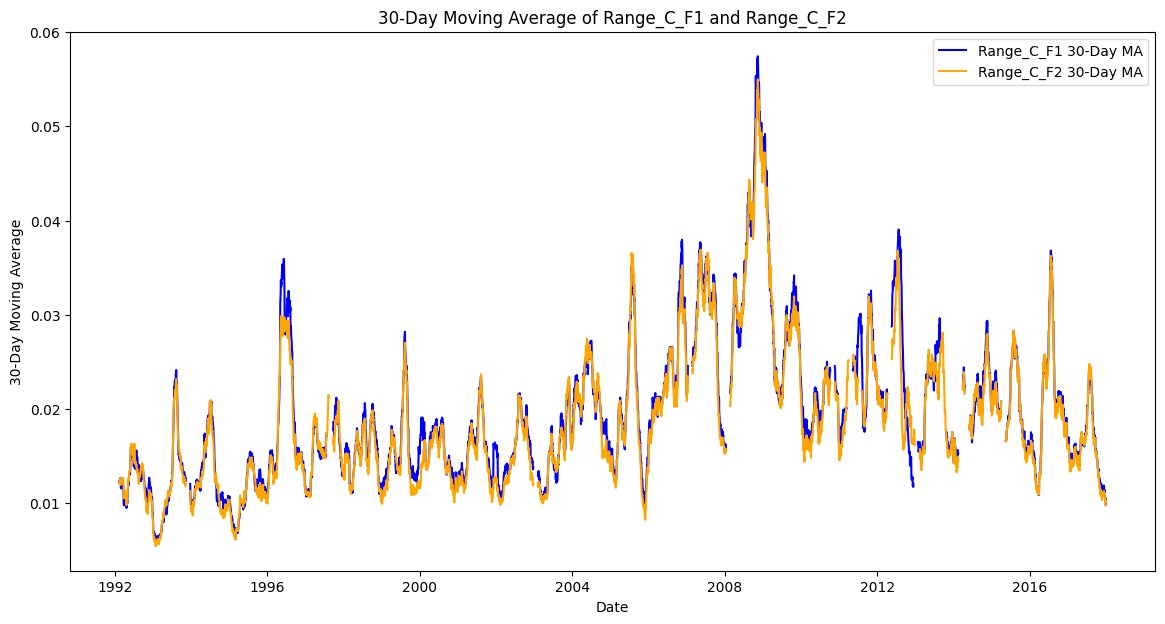

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df_corn_filtered['Date'], df_corn_filtered['Range_C_F1_MA30'], label='Range_C_F1 30-Day MA', color='blue')
plt.plot(df_corn_filtered['Date'], df_corn_filtered['Range_C_F2_MA30'], label='Range_C_F2 30-Day MA', color='orange')
plt.xlabel('Date')
plt.ylabel('30-Day Moving Average')
plt.title('30-Day Moving Average of Range_C_F1 and Range_C_F2')
plt.legend()
plt.show()

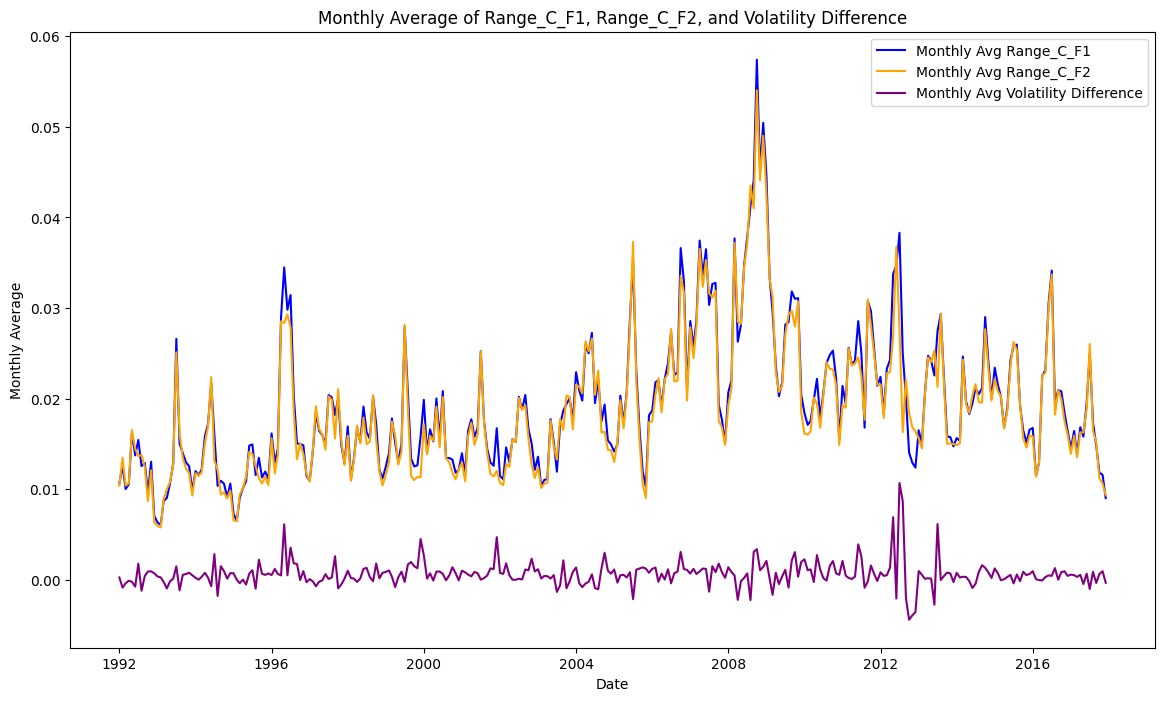

In [ ]:
monthly_avg.index = pd.to_datetime(monthly_avg.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
plt.figure(figsize=(14, 8))
plt.plot(monthly_avg.index, monthly_avg['Range_C_F1'], label='Monthly Avg Range_C_F1', color='blue')
plt.plot(monthly_avg.index, monthly_avg['Range_C_F2'], label='Monthly Avg Range_C_F2', color='orange')
plt.plot(monthly_avg.index, monthly_avg['Volatility_Difference'], label='Monthly Avg Volatility Difference', color='purple')
plt.xlabel('Date')
plt.ylabel('Monthly Average')
plt.title('Monthly Average of Range_C_F1, Range_C_F2, and Volatility Difference')
plt.legend()
plt.show()

The next graph shows the volatility difference (Volatility_Difference) over time as a blue line, with outliers overlaid as red points. The outliers represent anomalous events in the data, where the difference between the two price ranges was significantly high or low.

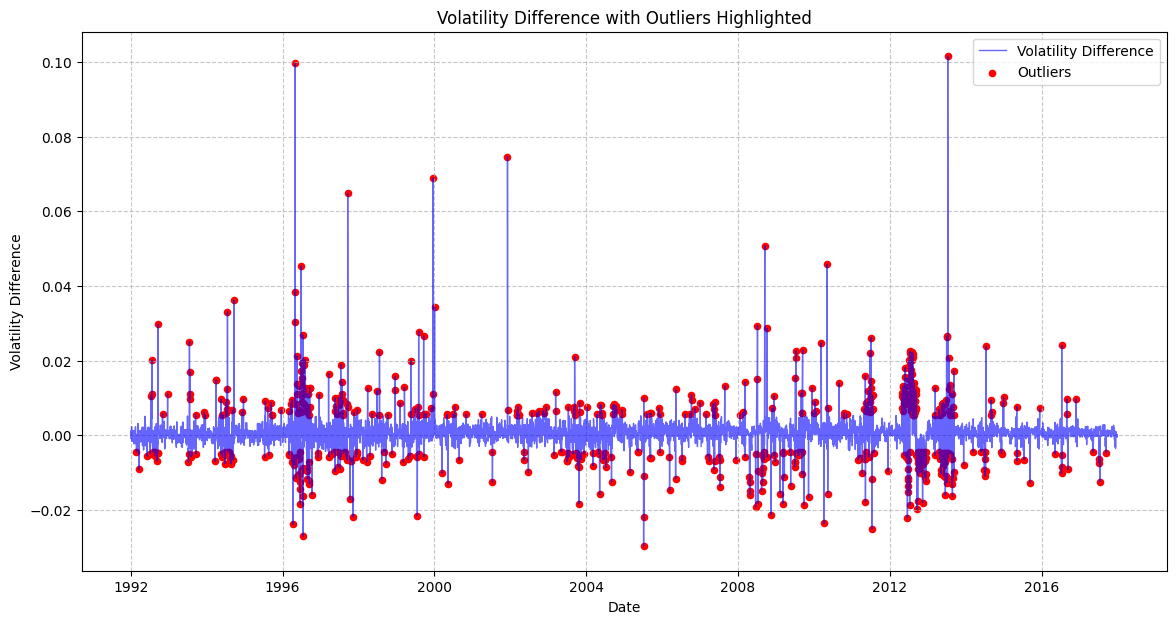

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df_corn_filtered['Date'], df_corn_filtered['Volatility_Difference'], label='Volatility Difference', color='blue', alpha=0.6, linewidth=1)
plt.scatter(outliers['Date'], outliers['Volatility_Difference'], color='red', label='Outliers', s=20)
plt.xlabel('Date')
plt.ylabel('Volatility Difference')
plt.title('Volatility Difference with Outliers Highlighted')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In the next step, we analyze the outliers identified earlier by grouping them by month and year. For each month, we count the number of outliers and define a threshold based on the 75th percentile. Months where the number of outliers exceeds this threshold are considered "anomalously unstable." A monthly indicator is then created, taking the value 1 for months above the threshold and 0 for those below. Finally, we visualize the results with a step plot, where each step highlights periods with a significantly high number of outliers, helping to identify moments of heightened market volatility.

<ipython-input-52-9fdd1ba75cf5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['Year'] = outliers['Date'].dt.year
<ipython-input-52-9fdd1ba75cf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['Month'] = outliers['Date'].dt.month


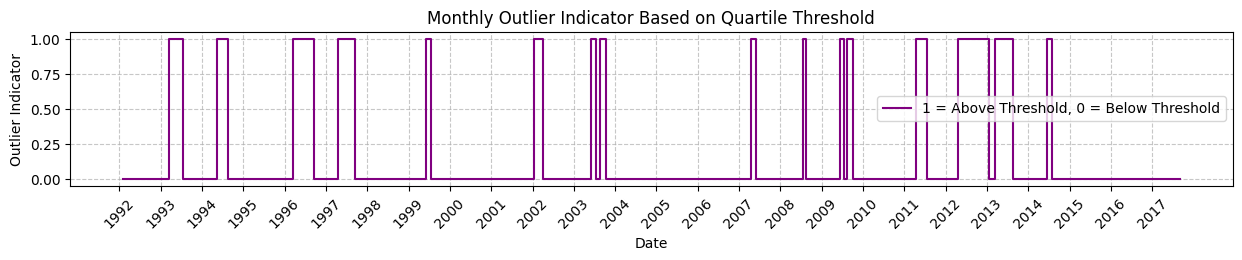

In [ ]:
outliers['Year'] = outliers['Date'].dt.year
outliers['Month'] = outliers['Date'].dt.month


monthly_outlier_count = outliers.groupby(['Year', 'Month']).size()
outlier_threshold = monthly_outlier_count.quantile(0.75)

monthly_outlier_indicator = (monthly_outlier_count > outlier_threshold).astype(int)

monthly_outlier_indicator.index = pd.to_datetime(monthly_outlier_indicator.index.map(lambda x: f"{x[0]}-{x[1]}-01"))

plt.figure(figsize=(15, 2))
plt.step(monthly_outlier_indicator.index, monthly_outlier_indicator, where='mid', color='purple', label='1 = Above Threshold, 0 = Below Threshold')
plt.xlabel('Date')
plt.ylabel('Outlier Indicator')
plt.title('Monthly Outlier Indicator Based on Quartile Threshold')

plt.legend()

years = pd.date_range(start="1992-01-01", end=monthly_outlier_indicator.index.max(), freq='YS')
plt.xticks(years, [year.year for year in years], rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Next, we focus on positive outliers, which are cases where the Volatility_Difference was unusually high and than we focus on negative outliers, representing cases where the Volatility_Difference was exceptionally low, falling below the lower IQR threshold.

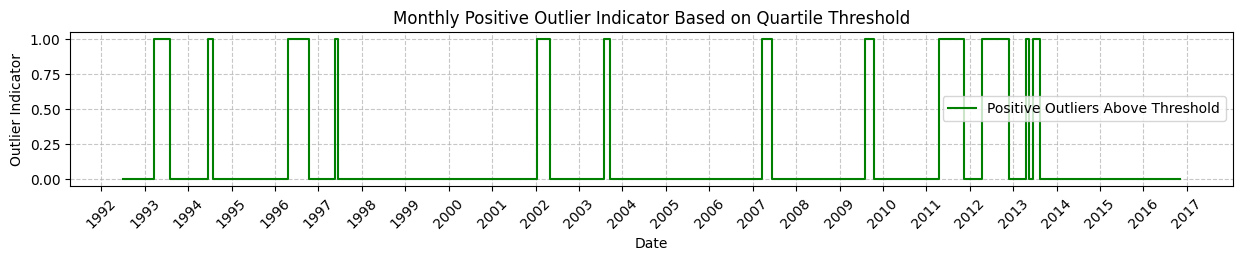

In [ ]:
positive_outliers = outliers[outliers['Volatility_Difference'] > (q3 + 1.5 * iqr)]

monthly_positive_outlier_count = positive_outliers.groupby(['Year', 'Month']).size()

positive_outlier_threshold = monthly_positive_outlier_count.quantile(0.75)
monthly_positive_outlier_indicator = (monthly_positive_outlier_count > positive_outlier_threshold).astype(int)

monthly_positive_outlier_indicator.index = pd.to_datetime(monthly_positive_outlier_indicator.index.map(lambda x: f"{x[0]}-{x[1]}-01"))

plt.figure(figsize=(15, 2))
plt.step(monthly_positive_outlier_indicator.index, monthly_positive_outlier_indicator, where='mid', color='green', label='Positive Outliers Above Threshold')
plt.xlabel('Date')
plt.ylabel('Outlier Indicator')
plt.title('Monthly Positive Outlier Indicator Based on Quartile Threshold')
plt.legend()
plt.xticks(years, [year.year for year in years], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

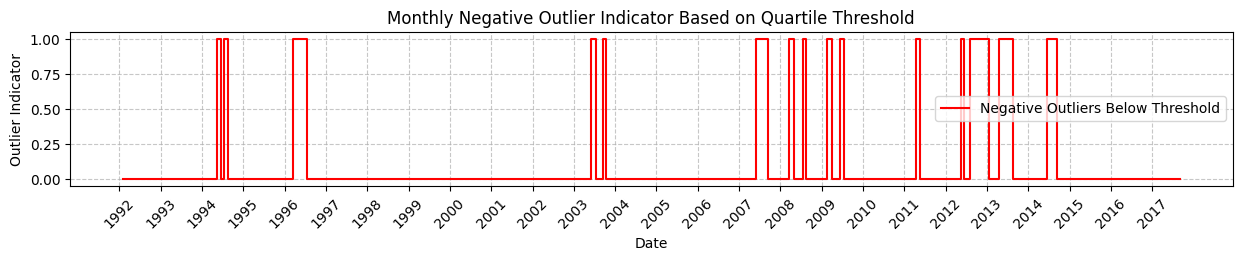

In [ ]:
negative_outliers = outliers[outliers['Volatility_Difference'] < (q1 - 1.5 * iqr)]

monthly_negative_outlier_count = negative_outliers.groupby(['Year', 'Month']).size()

negative_outlier_threshold = monthly_negative_outlier_count.quantile(0.75)
monthly_negative_outlier_indicator = (monthly_negative_outlier_count > negative_outlier_threshold).astype(int)

monthly_negative_outlier_indicator.index = pd.to_datetime(monthly_negative_outlier_indicator.index.map(lambda x: f"{x[0]}-{x[1]}-01"))

plt.figure(figsize=(15, 2))
plt.step(monthly_negative_outlier_indicator.index, monthly_negative_outlier_indicator, where='mid', color='red', label='Negative Outliers Below Threshold')
plt.xlabel('Date')
plt.ylabel('Outlier Indicator')
plt.title('Monthly Negative Outlier Indicator Based on Quartile Threshold')
plt.legend()
plt.xticks(years, [year.year for year in years], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Finally, we combine the information on total, positive, and negative outliers into a single plot. This combined plot summarizes the temporal trends of anomalies, highlighting periods of instability or unusual market behavior. By visualizing all three types of outliers together, we can compare their distributions over time and identify significant patterns or anomalies in the corn futures market.

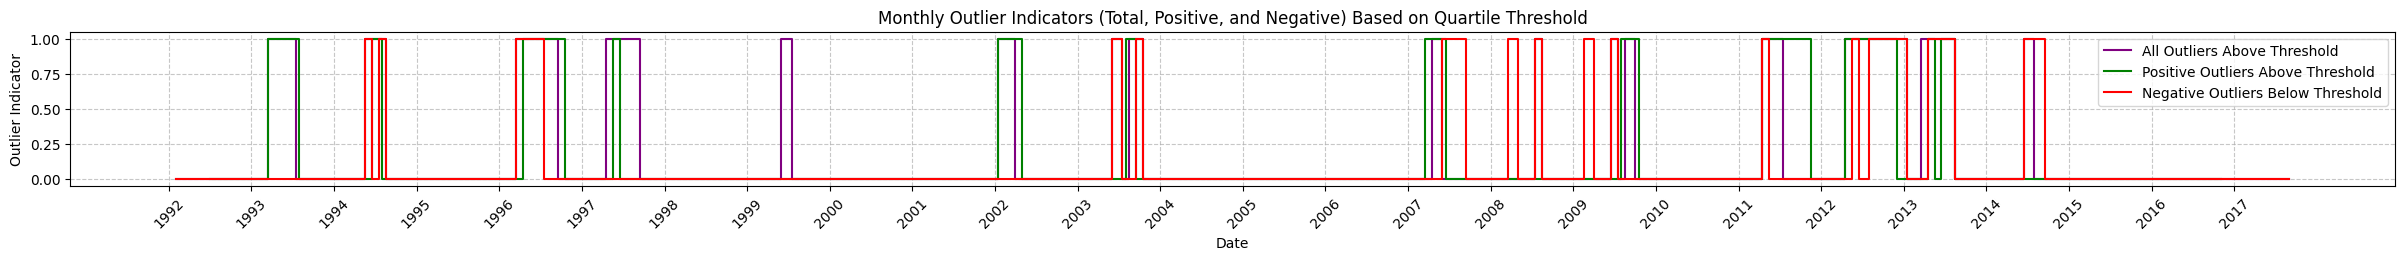

In [ ]:
plt.figure(figsize=(30, 2))

plt.step(monthly_outlier_indicator.index, monthly_outlier_indicator, where='mid', color='purple', label='All Outliers Above Threshold')

plt.step(monthly_positive_outlier_indicator.index, monthly_positive_outlier_indicator, where='mid', color='green', label='Positive Outliers Above Threshold')

plt.step(monthly_negative_outlier_indicator.index, monthly_negative_outlier_indicator, where='mid', color='red', label='Negative Outliers Below Threshold')

plt.xlabel('Date')
plt.ylabel('Outlier Indicator')
plt.title('Monthly Outlier Indicators (Total, Positive, and Negative) Based on Quartile Threshold')
plt.legend()
plt.xticks(years, [year.year for year in years], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [ ]:
monthly_total_outliers = outliers.groupby(['Year', 'Month']).size()
monthly_positive_outliers = positive_outliers.groupby(['Year', 'Month']).size()
monthly_negative_outliers = negative_outliers.groupby(['Year', 'Month']).size()

# Trasforma l'indice in datetime per facilitare il tracciamento su base temporale
monthly_total_outliers.index = pd.to_datetime(monthly_total_outliers.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
monthly_positive_outliers.index = pd.to_datetime(monthly_positive_outliers.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
monthly_negative_outliers.index = pd.to_datetime(monthly_negative_outliers.index.map(lambda x: f"{x[0]}-{x[1]}-01"))

price_data = pd.DataFrame({
    'Total_Outliers': monthly_total_outliers,
    'Positive_Outliers': monthly_positive_outliers,
    'Negative_Outliers': monthly_negative_outliers
}).fillna(0)

# **HYPOTHESIS TESTING:YEARLY AVG PRICE INCREASE**

In [ ]:
print(f"Pivot_2:")
print(pivot_2.head())
print(pivot_2.shape)
print(f"Pivot_3:")
print(pivot_3.head())
print(pivot_3.shape)
print(f"Pivot_4:")
print(pivot_4.head())
print(pivot_4.shape)

Pivot_2:
STATE       STATEWISE_AVERAGE       STD  YEARLY_AVG  YEARLY_STD  \
DATE                                                              
2001-01-01           1.978750  0.177083    1.933906    0.186434   
2001-02-01           1.993750  0.197716    1.933906    0.186434   
2001-03-01           1.986250  0.185540    1.933906    0.186434   
2001-04-01           1.946250  0.178769    1.933906    0.186434   
2001-05-01           1.878125  0.230310    1.933906    0.186434   

STATE       YEARLY_AVG_STD  MONTHLY_ABOVE_YEARLY  MONTHLY_BELOW_MINUS_YEARLY  
DATE                                                                          
2001-01-01         2.12034                     0                           0  
2001-02-01         2.12034                     0                           0  
2001-03-01         2.12034                     0                           0  
2001-04-01         2.12034                     0                           0  
2001-05-01         2.12034                     

The hypothesis we are going to test is wether or not the average price for year 2024 is greater than the 2001's one. Hence we choose as a null hypothesis that of it being smaller or equal to the 2001 one in order to see if there is significant evidence that allows us to reject it.

In [ ]:
'''
H0 : The average price for year 2024 is higher than for year 2001
Ha: The average price for year 2024 is not higher than for year 2001
'''

pivot_5 = pivot_2.copy()
# drop every colum except the first one
pivot_5 = pivot_5.drop(columns=pivot_5.columns[1:])
pivot_5['YEAR'] = pivot_5.index.year
pivot_5 = pivot_5.reset_index(drop=True)
pivot_5 = pivot_5.set_index('YEAR')

#print(pivot_5.head())
#print(pivot_5.shape)

# Now we can test the hypothesis
year_2001 = pivot_5.loc[2001]
year_2024 = pivot_5.loc[2024]

#print(year_2001)
#print(year_2024)

from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(year_2024, year_2001, alternative='greater')

alpha = 0.05

print(f"Null hyp.: the 2024 avg is not greater than the 2001 one")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

if p_val < alpha:
    print("Reject the null hypothesis: Conclusion: 2024's average is greter than the 2001's one")
else:
    print("Fail to reject the null hypothesis")

Null hyp.: the 2024 avg is not greater than the 2001 one
T-statistic: [30.88246272]
P-value: [5.2715813e-18]
Reject the null hypothesis: Conclusion: 2024's average is greter than the 2001's one


Conclusion: Reject!

In [ ]:
mean_2001 = year_2001.mean()
mean_2024 = year_2024.mean()

print(f"Mean for 2001: {mean_2001}")
print(f"Mean for 2024: {mean_2024}")

Mean for 2001: STATE
STATEWISE_AVERAGE    1.933906
dtype: float64
Mean for 2024: STATE
STATEWISE_AVERAGE    4.325625
dtype: float64


**SECTION I - REGRESION ON WEATHER CONDITIONS AND PRICES**

We have prepared data for extraordinary months, in terms of both weather conditions and difference between short-length and long-length contracts. Our goal is to regress on weather conditions to predict exceptionally negative and exceptionally positive months.

Initially, we focused on a binary representation of extraordinary months. Using data from 2004 for training and testing data from 1992 to 2017, we achieved a very low level of accuracy. While the results are not entirely random, suggesting some relationship between weather and price, we believe that either the features are insufficient or the precision of the existing features is inadequate.

To address this, instead of classifying months as special or non special — which relies on an arbitrary threshold (the 0.9 quantile) — we used the percentage of exceptionality for each month, previously computed during data cleaning and exploratory data analysis (EDA). We applied a similar approach to the training labels by considering the number of special "economic" days for each month, another factor computed in the cleaning and EDA phase.

This regression approach again produced imprecise results. While it fails to accurately predict the exact number of exceptional days per month, it performs reasonably well in identifying months with a moderate number of exceptional days.

This leads us to conclude that either the available features are insufficient or the correlation between weather and contract exceptionality is not particularly strong. However, the fact that both approaches show some level of correlation with the original data suggests that the problem is more likely a matter of features.


In [ ]:
# prepare the price dataset for the linear regression
price_t = price_data.reset_index().copy()
price_t['DATE'] = pd.to_datetime(price_t['index'])
price_t['YEAR'] = price_t['DATE'].dt.year
price_t['MONTH'] = price_t['DATE'].dt.month

max_year = price_t["YEAR"].max()
min_year = price_t["YEAR"].min()
print("Min year: " + str(min_year))

print("Max year: " + str(max_year))

all_months = pd.DataFrame([
    {'YEAR': year, 'MONTH': month}
    for year in range(min_year, max_year + 1)
    for month in range(1, 13)
])

prices_t = pd.merge(all_months, price_t, on=['YEAR', 'MONTH'], how='left')
prices_t['Positive_Outliers'] = prices_t['Positive_Outliers'].fillna(0).astype(int)
prices_t['Negative_Outliers'] = prices_t['Negative_Outliers'].fillna(0).astype(int)
prices_t = prices_t.fillna(0)

prices_t = prices_t.sort_values(by=['YEAR', 'MONTH']).reset_index(drop=True)
prices_t['LABEL'] = np.where(prices_t['MONTH'] == 1, prices_t['YEAR'].astype(str), "")
prices_t['DATE'] = prices_t['MONTH'].astype(str) + "_" + prices_t['YEAR'].astype(str)
prices_t = prices_t.rename(columns={'Negative_Outliers': 'negative', 'Positive_Outliers': 'positive'})
prices_t = prices_t[["YEAR","MONTH","positive","negative","DATE","LABEL"]]
prices_t.head(400)


Min year: 1992
Max year: 2017


,YEAR,MONTH,positive,negative,DATE,LABEL
0,1992,1,0,0,1_1992,1992
1,1992,2,0,1,2_1992,
2,1992,3,0,1,3_1992,
3,1992,4,0,0,4_1992,
4,1992,5,0,0,5_1992,
...,...,...,...,...,...,...
307,2017,8,0,0,8_2017,
308,2017,9,0,1,9_2017,
309,2017,10,0,0,10_2017,
310,2017,11,0,0,11_2017,


In [ ]:
# prepare the price weather exceptionality binary dataset for the linear regression
weather_t_bin = weather_bin.copy()
weather_t_bin = weather_t_bin[weather_t_bin['YEAR']<=max_year]
weather_t_bin = weather_t_bin[weather_t_bin['YEAR']>=min_year]
weather_t_bin = pd.merge(all_months, weather_t_bin, on=['YEAR', 'MONTH'], how='left')
weather_t_bin['colder'] = weather_t_bin['colder'].fillna(0).astype(int)
weather_t_bin['hotter'] = weather_t_bin['hotter'].fillna(0).astype(int)
weather_t_bin['wetter'] = weather_t_bin['wetter'].fillna(0).astype(int)
weather_t_bin['drier'] = weather_t_bin['drier'].fillna(0).astype(int)
weather_t_bin = weather_t_bin.fillna(0)
weather_t_bin['LABEL'] = np.where(weather_t_bin['MONTH'] == 1, weather_t_bin['YEAR'].astype(str), "")
weather_t_bin['DATE'] = weather_t_bin['MONTH'].astype(str) + "_" + weather_t_bin['YEAR'].astype(str)
weather_t_bin.head(400)

,YEAR,MONTH,colder,hotter,wetter,drier,LABEL,DATE
0,1992,1,0,0,0,0,1992,1_1992
1,1992,2,0,0,0,0,,2_1992
2,1992,3,0,0,0,0,,3_1992
3,1992,4,0,0,0,0,,4_1992
4,1992,5,0,0,0,1,,5_1992
...,...,...,...,...,...,...,...,...
307,2017,8,0,0,0,0,,8_2017
308,2017,9,0,0,0,0,,9_2017
309,2017,10,0,0,0,0,,10_2017
310,2017,11,0,0,0,0,,11_2017


In [ ]:
# express month exceptionality in binary format
prices_quartile = prices_t.copy()
quartiles = prices_quartile[['positive', 'negative']].quantile(0.90)
prices_quartile['positive'] = np.where(prices_quartile['positive'] >= quartiles['positive'] , 1, 0)
prices_quartile['negative'] = np.where(prices_quartile['negative'] >= quartiles['negative'] , 1, 0)

In [ ]:
# perform the linear regression, training up to 2005
modelP = LinearRegression()
modelN = LinearRegression()
Xt = weather_t_bin[weather_t_bin['YEAR']<2005][['hotter', 'colder', 'wetter', 'drier']]
yP = prices_quartile[prices_quartile['YEAR']<2005]['positive']
yN = prices_quartile[prices_quartile['YEAR']<2005]['negative']
modelP.fit(Xt, yP)
modelN.fit(Xt, yN)
X = weather_t_bin[['hotter', 'colder', 'wetter', 'drier']]

positive_predictions = modelP.predict(X)
negative_predictions = modelN.predict(X)
thresholdP = (positive_predictions.max() - positive_predictions.min())/2+0.1
thresholdN = (negative_predictions.max() - negative_predictions.min())/2+0.1
positive_predictions = (positive_predictions >= thresholdP).astype(int)
negative_predictions = (negative_predictions >= thresholdN).astype(int)

prediction = pd.DataFrame({
    "positive": positive_predictions,
    "negative": negative_predictions,
    "DATE": prices_quartile["DATE"],
    "LABEL": prices_quartile["LABEL"],
    "MONTH": prices_quartile["MONTH"],
    "YEAR": prices_quartile["YEAR"]
})

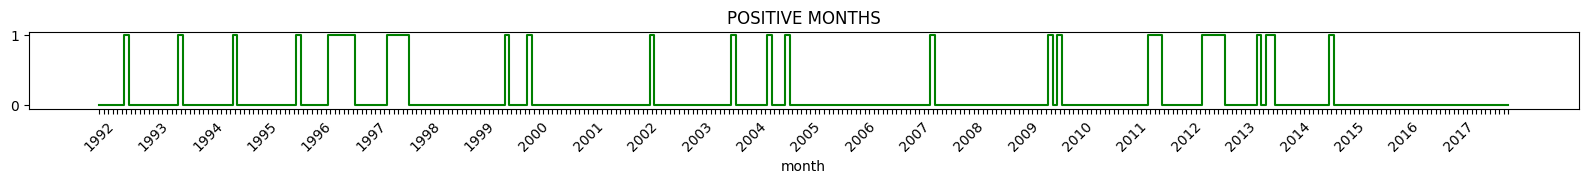

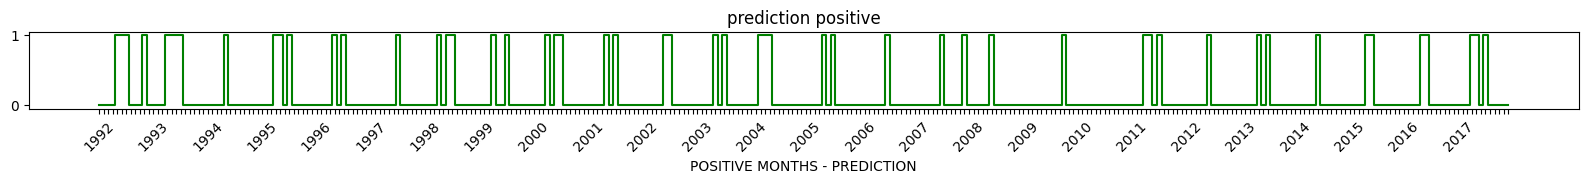

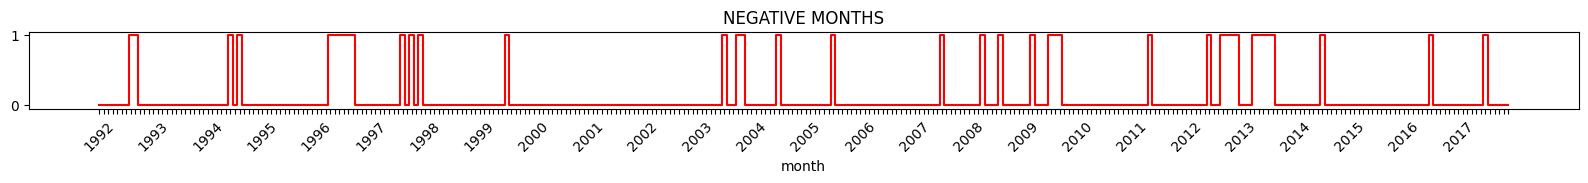

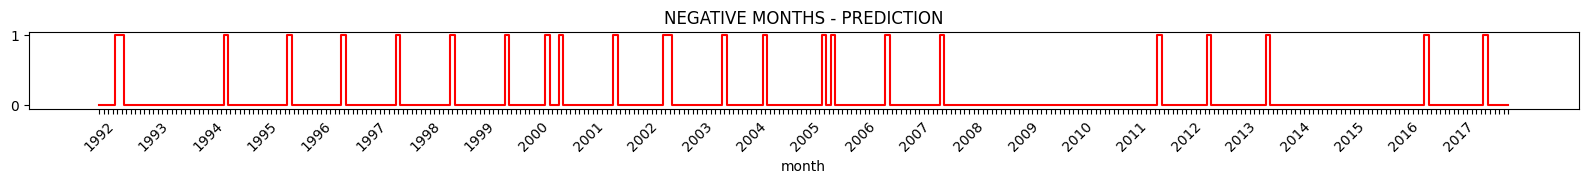

In [ ]:
# plot correct data and prediction

plt.figure(figsize=(20, 1))
plt.step(prices_quartile["DATE"], prices_quartile["positive"], where='mid', color='green')
plt.xlabel("month")
plt.title("POSITIVE MONTHS")
plt.xticks(ticks=range(len(prices_quartile['DATE'])), labels=prices_quartile['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(prediction["DATE"], prediction["positive"], where='mid', color='green')
plt.xlabel("POSITIVE MONTHS - PREDICTION")
plt.title("prediction positive")
plt.xticks(ticks=range(len(prediction['DATE'])), labels=prediction['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(prices_quartile["DATE"], prices_quartile["negative"], where='mid', color='red')
plt.xlabel("month")
plt.title("NEGATIVE MONTHS")
plt.xticks(ticks=range(len(prices_quartile['DATE'])), labels=prices_quartile['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(prediction["DATE"], prediction["negative"], where='mid', color='red')
plt.xlabel("month")
plt.title("NEGATIVE MONTHS - PREDICTION")
plt.xticks(ticks=range(len(prediction['DATE'])), labels=prediction['LABEL'], rotation=45)
plt.show()

In [ ]:
# prepare the price weather exceptionality percentage dataset for the linear regression
weather_t_perc = weather_perc.copy()
weather_t_perc = weather_t_perc[(weather_t_perc['YEAR'] <= max_year) & (weather_t_perc['YEAR'] >= min_year)]
weather_t_perc = pd.merge(all_months, weather_t_perc, on=['YEAR', 'MONTH'], how='left')
weather_t_perc['colder'] = weather_t_perc['colder'].fillna(0).astype(float)
weather_t_perc['hotter'] = weather_t_perc['hotter'].fillna(0).astype(float)
weather_t_perc['wetter'] = weather_t_perc['wetter'].fillna(0).astype(float)
weather_t_perc['drier'] =weather_t_perc['drier'].fillna(0).astype(float)
weather_t_perc = weather_t_perc.fillna(0)
weather_t_perc['LABEL'] = np.where(weather_t_perc['MONTH'] == 1, weather_t_perc['YEAR'].astype(str), "")
weather_t_perc['DATE'] = weather_t_perc['MONTH'].astype(str) + "_" + weather_t_perc['YEAR'].astype(str)
weather_t_perc.head(400)

,YEAR,MONTH,colder,hotter,wetter,drier,LABEL,DATE
0,1992,1,0.176533,0.371571,0.213174,0.000000,1992,1_1992
1,1992,2,0.072567,0.400601,0.198014,0.000000,,2_1992
2,1992,3,0.238459,0.329808,0.276000,0.000000,,3_1992
3,1992,4,0.273102,0.273853,0.302322,0.615064,,4_1992
4,1992,5,0.325291,0.308441,0.191740,0.758475,,5_1992
...,...,...,...,...,...,...,...,...
307,2017,8,0.285810,0.018315,0.251015,0.000000,,8_2017
308,2017,9,0.213762,0.342861,0.147780,0.000000,,9_2017
309,2017,10,0.201083,0.371374,0.289828,0.000000,,10_2017
310,2017,11,0.264359,0.239279,0.175452,0.000000,,11_2017


In [ ]:
# perform the linear regression, training up to 2005
modelP = LinearRegression()
modelN = LinearRegression()
Xt = weather_t_perc[weather_t_perc['YEAR']<2005][['hotter', 'colder', 'wetter', 'drier']]
yP = prices_t[prices_t['YEAR']<2005]['positive']
yN = prices_t[prices_t['YEAR']<2005]['negative']
X = weather_t_perc[['hotter', 'colder', 'wetter', 'drier']]
modelP.fit(Xt, yP)
modelN.fit(Xt, yN)

positive_predictions = (modelP.predict(X)).astype(int)
negative_predictions = (modelN.predict(X)).astype(int)

prediction = pd.DataFrame({
    "positive": positive_predictions,
    "negative": negative_predictions,
    "DATE": prices_t["DATE"],
    "LABEL": prices_t["LABEL"],
    "MONTH": prices_t["MONTH"],
    "YEAR": prices_t["YEAR"]
})

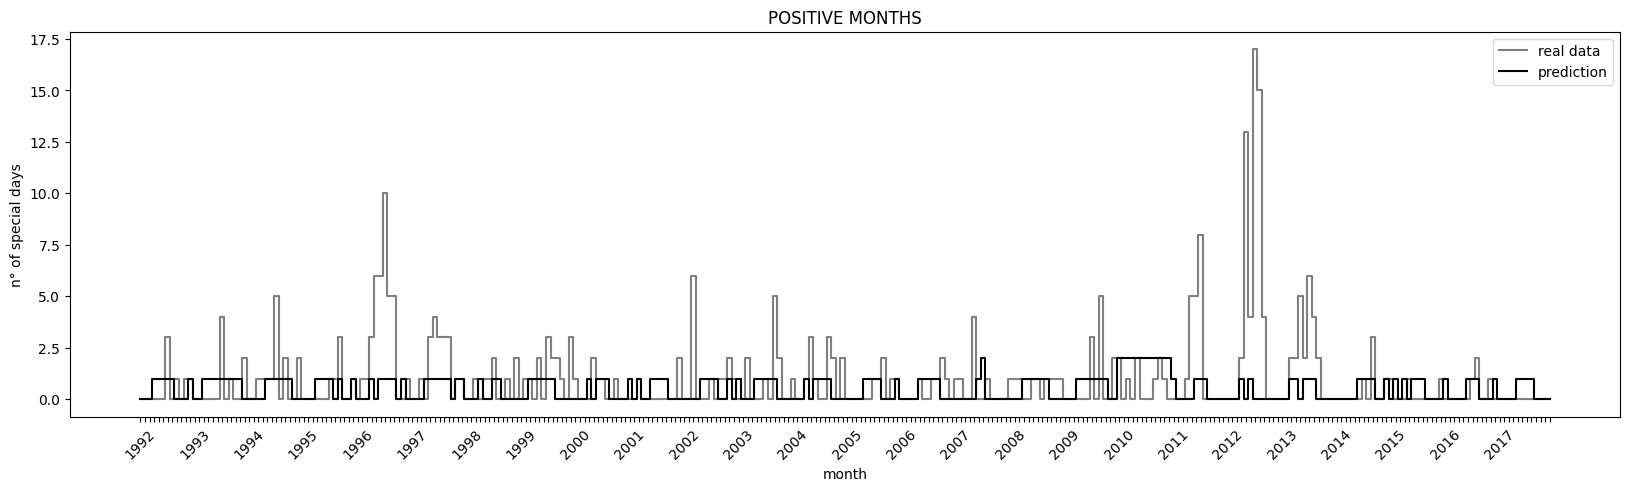

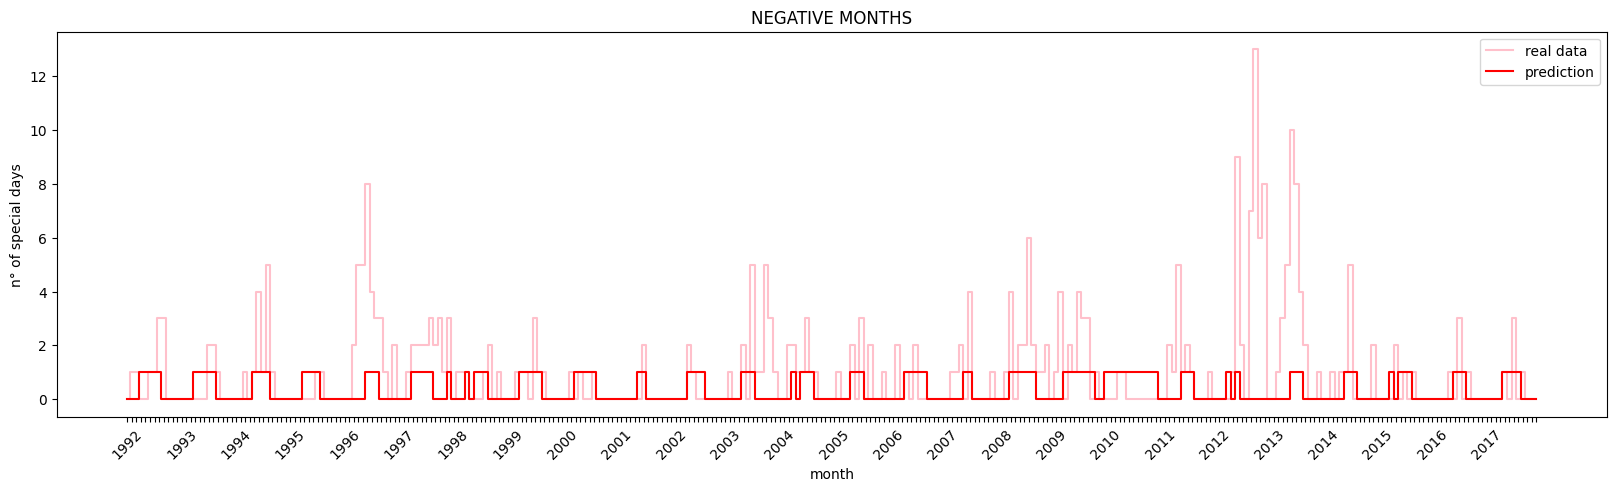

In [ ]:
# plot correct data and prediction

plt.figure(figsize=(20, 5))
plt.step(prices_t["DATE"], prices_t["positive"], where='mid', color='grey', label="real data")
plt.step(prediction["DATE"], prediction["positive"], where='mid', color='black', label="prediction")
plt.xlabel("month")
plt.ylabel("n° of special days")
plt.title("POSITIVE MONTHS")
plt.xticks(ticks=range(len(prediction['DATE'])), labels=prediction['LABEL'], rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.step(prices_t["DATE"], prices_t["negative"], where='mid', color='pink', label="real data")
plt.step(prediction["DATE"], prediction["negative"], where='mid', color='red', label="prediction")
plt.xlabel("month")
plt.ylabel("n° of special days")
plt.title("NEGATIVE MONTHS")
plt.xticks(ticks=range(len(prediction['DATE'])), labels=prediction['LABEL'], rotation=45)
plt.legend()
plt.show()

### Quadratic model prediction on predicting price given production, followed by a small NN


Hypothesis:
The relationship between corn production and price follows a non-linear pattern that is better captured by neural networks than simple polynomial models, suggesting complex market dynamics beyond basic supply-demand relationships.

This link is crucial because the weather affects production and it serves as an important intermediate step to see the causation effects on price.

Mean Squared Error: 0.0360
R² Score: 0.3641

Quadratic equation (x in millions of bushels):
y = 0.00000042x² + -0.00109117x + 4.3467


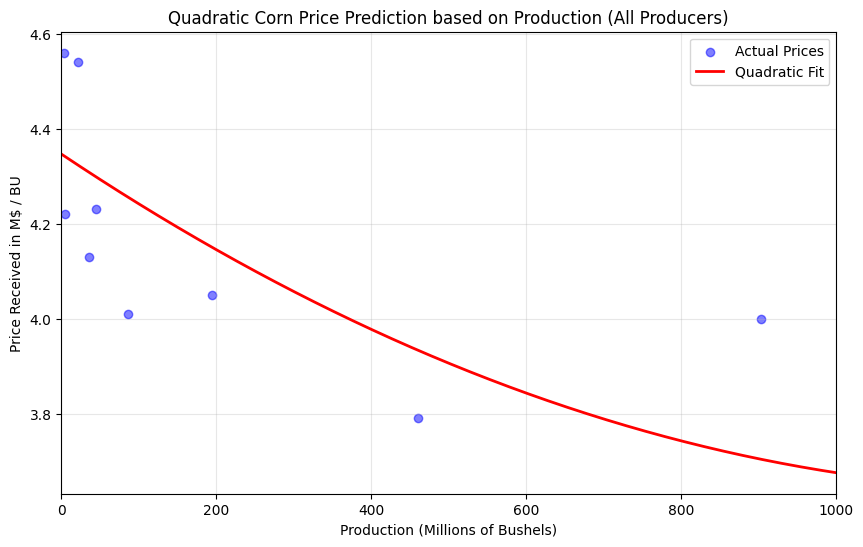

In [ ]:
# prepare the data from location_averages (all producers)
clean_data = location_averages.dropna()

# Scale down X values to millions
X = clean_data['PRODUCTION in BU'].values / 1_000_000  # Convert to millions of bushels
y = clean_data['PRICE RECEIVED in $ / BU'].values

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define quadratic function
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# fit using curve_fit with multiple initial guesses and choosing the best
best_fit = None
best_score = float('-inf')
initial_guesses = [
    [0.001, -0.1, 5],
    [-0.001, 0.1, 3],
    [0.0001, -0.01, 4],
    [-0.0001, 0.01, 4]
]

for guess in initial_guesses:
    try:
        popt, _ = curve_fit(quadratic, X_train, y_train, p0=guess)
        y_pred = quadratic(X_test, *popt)
        score = r2_score(y_test, y_pred)

        if score > best_score:
            best_score = score
            best_fit = popt
    except:
        continue

a, b, c = best_fit

# make predictions
y_pred = quadratic(X_test, a, b, c)

#print metrics
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
print(f'\nQuadratic equation (x in millions of bushels):')
print(f'y = {a:.8f}x² + {b:.8f}x + {c:.4f}')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices', alpha=0.5)

# create smooth curve for plotting (cropped at 1000)
X_smooth = np.linspace(0, 1000, 200)
y_smooth = quadratic(X_smooth, a, b, c)

plt.plot(X_smooth, y_smooth, color='red', label='Quadratic Fit', linewidth=2)
plt.xlabel('Production (Millions of Bushels)')
plt.ylabel('Price Received in M$ / BU')
plt.title('Quadratic Corn Price Prediction based on Production (All Producers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)  # Set x-axis limits
plt.show()

Basic quadratic model, not a great fit

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mean Squared Error: 0.0299
R² Score: 0.4725
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


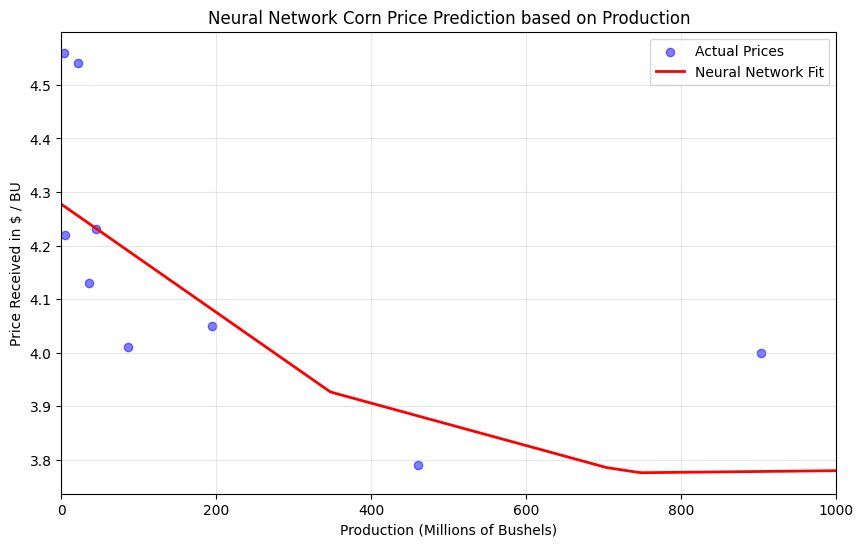

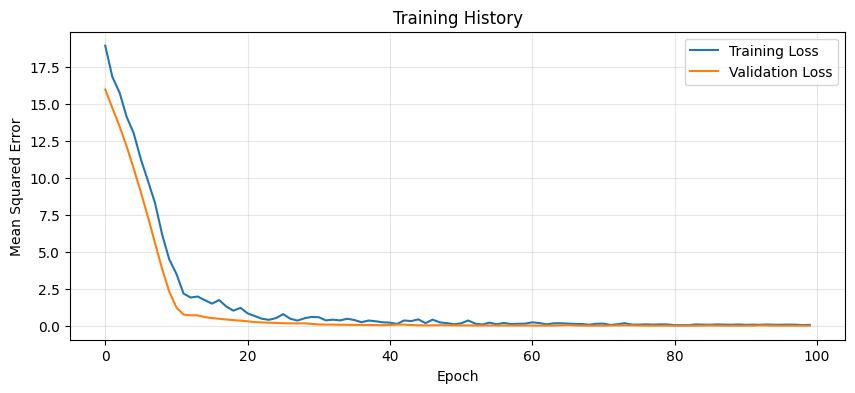

In [ ]:
# drop NA values from all producers so we have more data points
clean_data = location_averages.dropna()

# Scale down X values to millions for easier comprehension of the graph
X = clean_data['PRODUCTION in BU'].values / 1_000_000  # Convert to millions of bushels
y = clean_data['PRICE RECEIVED in $ / BU'].values

# reshape X for the neural network input
X = X.reshape(-1, 1)

# Split the data,and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create a simple neural network
model = Sequential([
    Dense(8, activation='relu', input_shape=(1,)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)
])

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train,
                   epochs=100,
                   batch_size=8,
                   validation_split=0.2,
                   verbose=0)

# Make predictions
y_pred = model.predict(X_test_scaled)

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')

# plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices', alpha=0.5)

X_smooth = np.linspace(0, 1000, 200).reshape(-1, 1)
X_smooth_scaled = scaler_X.transform(X_smooth)
y_smooth = model.predict(X_smooth_scaled)

plt.plot(X_smooth, y_smooth, color='red', label='Neural Network Fit', linewidth=2)
plt.xlabel('Production (Millions of Bushels)')
plt.ylabel('Price Received in $ / BU')
plt.title('Neural Network Corn Price Prediction based on Production')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)
plt.show()

# plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Small NN, much better fit compared to the poly model

#Reflection
## Hardest Parts:

### Data Integration Challenges:
- Merging weather data with corn prices due to different temporal granularities
- Handling multiple geographic scales (state-level vs specific weather stations)
- Dealing with missing values and inconsistent date formats across datasets

### Data Quality Issues:
- The corn futures dataset initially contained ranges instead of actual prices
- Weather data required extensive cleaning and outlier detection
- Production data needed careful scaling due to large numerical ranges

## Initial Insights:

### Weather Patterns:
- Successfully identified exceptional weather months using quartile-based analysis
- Created meaningful visualizations of weather trends in the Corn Belt region
- Established a methodology to flag unusual weather events

### Production-Price Relationship:
- Attempted both quadratic and neural network models to capture price-production relationships
- R² scores suggest there's a meaningful but complex relationship
- Neural network performed better than simple quadratic fit, indicating non-linear relationships

## Concrete Results:

### 1. Weather Analysis:
- Created comprehensive weather anomaly detection system
- Generated visualizations showing weather patterns over time
- Established baseline for normal vs exceptional weather conditions

### 2. Production Analysis:
- Successfully mapped major corn-producing states
- Created interactive visualizations of production distribution
- Established price-production relationships through multiple modeling approaches

### 3. Price Analysis
- Through our hypothesis testing, were able to find that the price of corn has increased since 2000.
## Current Biggest Problems:

### Causality Analysis:
- Need to establish clear causal links between weather events and price changes
- Challenge in handling time lags between weather events and market reactions
- Difficulty in isolating weather effects from other market factors
- Merge our new dataset that has daily prices of corn

### Model Refinement:
- Current models might be oversimplified
- Need to incorporate more variables (e.g., seasonal effects)
- Challenge in balancing model complexity with interpretability

## Project Track Assessment:
The project is on track with solid foundational work but needs focus in these areas:
- More sophisticated time series analysis
- Better integration of weather and price data
- More robust statistical validation of findings

## Project Viability:
The project is worth proceeding because:
- Clear relationships are emerging in the data
- Initial models show promising results
- The approach has practical applications for agricultural economics



## Next Steps:

### Focus More on Temporal Analysis:
- Add time series components to models
- Consider seasonal decomposition
- Analyze lag effects between weather and prices

### Enhance the Modeling Approach:
- Include more weather variables
- Consider ensemble methods
- Add economic indicators as control variables

### Improve Validation:
- Add cross-validation across different time periods
- Implement more robust statistical testing
- Create out-of-sample validation procedures

The project shows promise but would benefit from these enhancements to provide more robust and actionable insights.